## Introduction 

Hello! This is my very first Kernel. It is meant to give a grasp of a problem of speech representation. I'd also like to take a look on a features specific to this dataset. 

Content:<br>
* [1. Visualization of the recordings - input features](#visualization)
   * [1.1. Wave and spectrogram](#waveandspectrogram)
   * [1.2. MFCC](#mfcc)
   * [1.3. Sprectrogram in 3d](#3d)
   * [1.4. Silence removal](#resampl)
   * [1.5. Resampling - dimensionality reductions](#silenceremoval)
   * [1.6. Features extraction steps](#featuresextractionsteps)
* [2. Dataset investigation](#investigations)
   * [2.1. Number of files](#numberoffiles)
   * [2.2. Mean spectrograms and fft](#meanspectrogramsandfft)
   * [2.3. Deeper into recordings](#deeper)
   * [2.4. Length of recordings](#len)
   * [2.5. Note on Gaussian Mixtures modeling](#gmms)
   * [2.6. Frequency components across the words](#components)
   * [2.7. Anomaly detection](#anomaly)
* [3. Where to look for the inspiration](#wheretostart)

All we need is here:

In [ ]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pds
import scipy
# Math
import numpy as np

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import seaborn as sns

%matplotlib inline

<script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window.Plotly) {{require(['plotly'],function(plotly) {window.Plotly=plotly;});}}</script>


# 1. Visualization 
<a id="visualization"></a> 

There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) )
In speech recognition, I see two main tendencies - to input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

## 1.1. Wave and spectrogram:
<a id="waveandspectrogram"></a> 

Choose and read some file:

In [57]:
train_audio_path = './input/'
filename = '001.MP3'

# sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
samples, sample_rate = librosa.load(str(train_audio_path)+filename)
print(samples.shape)

(530496,)


Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear.
We need to assure that there are no 0 values as input to logarithm.

In [ ]:
def trim_samples(samples, check_period=1000, ratio_threshold=0.1):
    
    threshold = np.std(samples) * ratio_threshold
    start_idx = 0
    end_idx = len(samples)
    for i in range(0, len(samples), check_period):
        if (np.std(samples[i:i+check_period]) > threshold):
            start_idx = i
            break

    for i in range(len(samples), 0, -check_period):
        if (np.std(samples[i-check_period:i]) > threshold):
            end_idx = i
            break
    
    return samples[start_idx:end_idx]

In [58]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    
    # sample data를 이용해서 spectrogram을 그려줌
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    
    #spectrogram 결과에 log값을 씌워서명확하게 plot 할 수 있도록 도와줌
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in range (0, 8000) according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

Sample_rate가 22050이므로 range(0, 11000)이 맞음

Let's plot it:

In [59]:
scipy.stats.describe(samples)

DescribeResult(nobs=530496, minmax=(-0.5822169, 0.48143807), mean=-0.00060704094, variance=0.004609378, skewness=-0.21485596895217896, kurtosis=8.350374085898816)

In [60]:
np.std(samples)

0.067892335

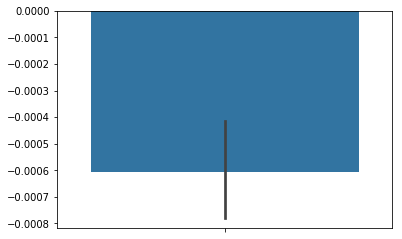

In [61]:
# 
# # sns.distplot(samples, hist=True)
# sns.barplot(y=samples)
# def reject_outliers(data, m=2):
#     return data[abs(data - np.mean(data)) < m * np.std(data)]

In [62]:
def re_sampling(target_shape=None):
    if not target_shape:
        target_shape = sample_rate
    sample_shape = samples.shape[0]
    assert target_shape < sample_shape
    step_size = sample_shape // target_shape
    re_samples = [samples[i] for i in range(0, sample_shape, step_size)]
    re_samples = re_samples[:target_shape]
    return np.array(re_samples)

In [63]:
re_samples = re_sampling()

In [64]:
re_samples.shape

(22050,)

In [86]:
scipy.stats.describe(spectrogram)

DescribeResult(nobs=2399, minmax=(array([-23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585, -23.02585, -23.02585, -23.02585, -23.02585, -23.02585,
       -23.02585,

Text(0.5,0,'Seconds')

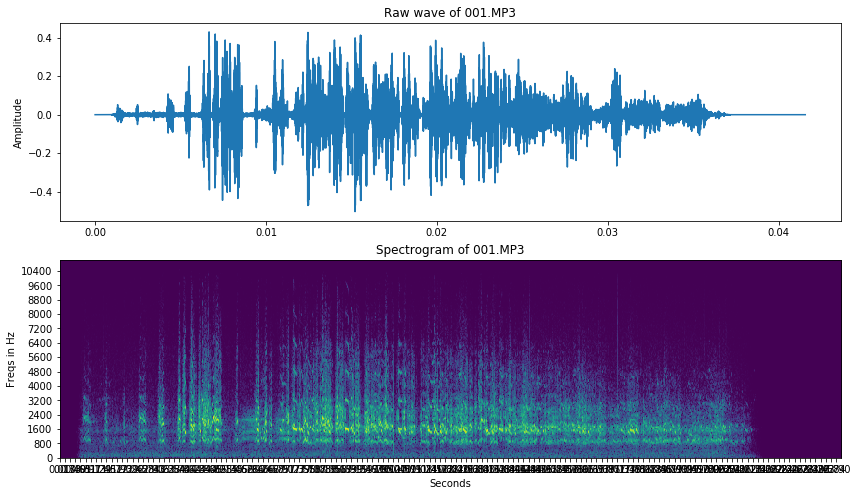

In [87]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
# spectrogram : X=time / Y=Freqs / Z(value)=amplitude

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(start=0, stop=sample_rate/len(samples), num=sample_rate), re_samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good *mean* and *std*!)

In [77]:
# scipy.stats.describe(spectrogram[0])


np.std(mean)

2.0255916

In [73]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std
# normalise data

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, [frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz](https://en.wikipedia.org/wiki/Psychoacoustics) It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

## 1.2. MFCC
<a id="mfcc"></a> 

If you want to get to know some details about *MFCC* take a look at this great tutorial. [MFCC explained](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) You can see, that it is well prepared to imitate human hearing properties.

You can calculate *Mel power spectrogram* and *MFCC* using for example *librosa* python package.


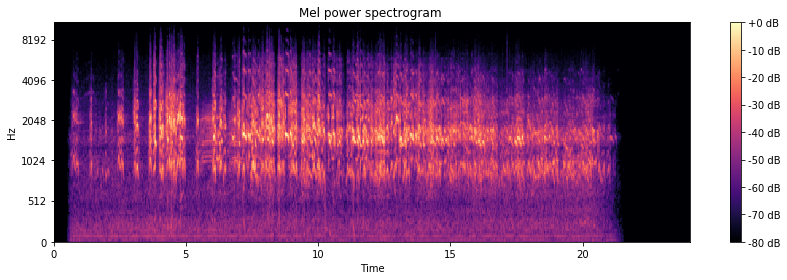

In [78]:

# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

'''
def melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
                   power=2.0, **kwargs):

    Compute a mel-scaled spectrogram.

    If a spectrogram input `S` is provided, then it is mapped directly onto
    the mel basis `mel_f` by `mel_f.dot(S)`.

    If a time-series input `y, sr` is provided, then its magnitude spectrogram
    `S` is first computed, and then mapped onto the mel scale by
    `mel_f.dot(S**power)`.  By default, `power=2` operates on a power spectrum.
'''

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))

# Time len(samples) / sample_rate 자동으로 되는듯 함
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
sample_rate

plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


In [41]:
mfcc.shape

(13, 44)

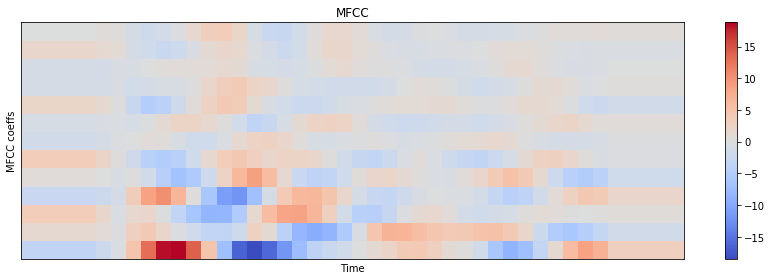

In [40]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, *MFCC*  or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example *MFCC* decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a

It is your decision which to choose!

## 1.3. Spectrogram in 3d
<a id="3d"></a> 

By the way, times change, and the tools change. Have you ever seen spectrogram in 3d?

In [43]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = {
        "yaxis" : {"title" :'Frequencies', "range":np.ndarray([np.int32(v) for x, v in enumerate(freqs) if x % 10 == 0])} ,
        "xaxis" : {"title" :'Time', "range":np.ndarray([int(v) for x, v in enumerate(times) if x % 10 == 0])},
        "zaxis" : {"title" :'Log amplitude'}
    }
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [36]:
len([v for x, v in enumerate(times) if x % 7 == 0])

14

(Don't know how to set axis ranges to proper values yet. I'd also like it to be streched like a classic spectrogram above..)

## 1.4. Silence removal
<a id="silenceremoval"></a> 

Let's listen to that file

In [42]:
ipd.Audio(samples, rate=sample_rate)

<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRmisAABXQVZFZm10IBAAAAABAAEAIlYAAESsAAACABAAZGF0YUSsAAAuAAMAzf/V/wAAIQAjAP3/0//S//b/JwBKAEUAJAAEAPb/+f8JACEANgAtAAUA4//i/wUAMQA+AB4A6P+7/7b/2v8EAA8A6P+i/3T/gP+0/+r////e/6D/g/+n//H/JwAiAOn/p/+H/6T/+f9KAFQAGgDf/8j/2f8VAGIAdgA+APb/0//j/xMARABOACgA7//M/9L/9v8ZABsA8v/B/7P/wP/R/+P/7P/f/83/0//t//z/+f/3//3/9v/f/8v/yf/U/9//3P/M/8f/2f/o/+D/1P/a/+f/7//s/9v/zf/Q/9z/7/8IABgAEQD9/+z/8/8aAEkAYABYAD8AKwAwAEsAaAB3AG8AVAA6ACgAHAAbACgAOAA0AB0ABQD6/wQAIwA6AD4AOwAxACEAJQA/AFAAVABPADMAFAAZADgASAA8ACIABADj/8//1//u/wIADwAPAAUAAwD//+j/2P/k/+z/3P/X/+r//P////v/+v/8/wAAAAD6//X/8P/v//r/CgASAAkA+P/p/+b/8f8BAAoAAADc/7b/r//O//P/+v/q/9j/yv/H/+D/BwAWAPz/yP+a/5X/yf8NADEAJQD6/8P/qf/L/w0ALgANAL//c/9g/5j/7P8eABcA5f+y/63/2v8WAD4APwAXAO3/6P8LAEgAfgCCAEkAAwDt/w0ASwB7AHwAVAAkAAcABAAVACcAIgD6/8b/rv/C//f/IAAeAAAA6//j/97/5v8AABEABwDl/73/qf++//D/CgD2/9X/zP/X/+P/8P/8//v/6P/Q/8n/2v/z/wQABwABAP///P/0//D/9v8EABwAJgAUAAAAAAALACMAQwBUAE4APgAuADEATwBsAHEAYgBDAB4AFQAtAEUARAAuABIAAAD9////CAAYACAAHAAYABoAHAAcACQALAAhAAwAAQD8//v/CQAgACYAEgD3/+X/4P/m//L//P/8//P/4v/W/+L///8OAAoAAwD9//P/8P/8/wsAEwAMAP3/8//7/woADwAHAPj/5//b/97/8/8JABEACgD9/+b/2P/h/+n/3f/M/8H/sv+h/5z/qf/I/+v/+v/v/9n/zf/Q/9f/1P/O/8n/xf/J/9v/9f8AAO//0v/O/+X/+/8DAAEA9P/j/+f///8PABEADAAHAAEA+v/9/wsAFQAaACAAIgAbABYAEgARABcAGwARAAIA+f/s/+b/BQA/AFQAKgDv/9j/8v8jAEoASwAjAO7/1f/9/04AigB9ACYAwf+a/9H/OgCRAJIALwCz/3b/nP8RAJkAyABxAOX/i/+a/xAAmwDMAIwAHQDQ/97/QgCkALgAeAAGAK7/uf8WAGsAdgA8AO3/xv/b/wEAEgAMAAAA9f/1/wkAIgAfAPb/xf+0/87/9f/+/+X/vP+a/5b/wP8AACUADgDG/4X/jP/U/yEAQQAiANP/jv+O/8r/BgAYAPT/sf94/2//m//b////7f+1/4P/gP+i/8T/1//h/9n/wP+4/9b//P8HAP7/5//H/7j/0//4/wEAAAD8//H/7f/8/wsADgANAA0AFQAmADQAOAAxACEAFwAmAEYAWwBNACQAAwAHACYAPAA3ABsA+f/l//f/LABcAE8AAwC2/6X/5/9ZAKYAiwAfALf/nv/s/2wAuQCQAAwAi/9i/7T/SwCrAIAA+f96/13/0P+LAO8ArgAIAHL/Uv/D/2sAxACQAPr/c/9r/+n/hADBAG4Aw/9B/07/0/9dAI4ASgC9/1D/Yv/k/24AlAAvAIj/Kv9d//X/igC2AFEAs/9c/3z/8P9sAJcASwDJ/3z/of8kAKMAtABXAOv/u//a/zQAlACvAGcA+f++/93/LwBtAGUAGQDG/6P/v////zIAKADm/6v/q//h/yQASAAxAO3/tP+3/+n/GQAtABsA5f+t/6P/yf/+/yEAJQAJAOX/z//O/9X/3//1/xIAFAD1/9z/4f/1/wQACgAFAP7/8P/d/9X/2//e/93/3v/e/97/1/+7/5T/gP+e/+f/KQAyAPz/q/+A/6j/DQBrAIUASwDk/5H/j//z/3oAqwBkAPn/sv+q/+r/QwBcACMA3P/C/+L/HwBLAD8A+v+z/6j/2f8VACcA7P+P/23/pv8NAFcAQwDd/4T/gv/O/z4AjwCGACsAy/+3/wwAiwDNAKoAPQDH/5//5P9RAIsAeQA0AOf/x//7/1kAfwBHAPX/0/8AAFoAkQBiAO3/k/+T/+H/QgBvADgAwf94/6n/LwCiAKgAPgC+/4f/vv8+AKQAjAD7/2D/Ov+l/z8AjgBZAMb/Sf9c/+j/WQBYAPP/c/9M/7D/OgB2AEYAxv9R/2D/7v96AKAAUADN/4H/qv8RAFwAVgAHAKn/iv/S/0sAmACCACIAx/+1/+//PABkAEwAEQDy/wMAKABAADUA+v+r/4T/nv/S//r/BwDw/7r/iv+C/6H/1/8AAPj/xv+l/7r/+P9AAHEAawA2AP3/5P8AAEcAggByABgAuf+T/7//HQBuAHUAKQDC/5D/uv8iAIkAowBbAPb/vv/N/xcAZwB7AE4ADgDb/9T/DQBZAHAASAAPAOj/3//3/x0ALQAaAAIA//8HABEAGAAOAO//zv/N//H/FAATAPP/y/+t/6//2/8PACAAAADS/8f/7P8jAEUALQDl/6n/o//D/+v/AADv/8D/of+x/93/9//p/8T/pv+j/8T/7v8AAAAABQAEAPj/8P/0//z/AQAEAPz/4v/B/7P/yf/9/ygAJQD//9z/1f/s/wsADwD5/+b/3P/U/+b/CAANAPD/2v/s/yAAUQBLAA8A2f/W//z/IAAwACkAEQD//w0AMgBLAE4ANwD8/8X/zP8AACwAPwA1AAwA6//0/wsAFQAeACgAHAAHAAYAFwAiAB4AEgAKAAsAEgAbAB8AGAATABQAFQAXABwAFAD8/+X/5P/8/xYAEQD2/+f/9P8LABsAHQAVAAcA/f8JADkAbwBtACEAzP+6//L/OABPACgA9f/o//P/8v/x/xAAOQA5AA8A6v/W/83/6/87AHoAYAAAAJ//ef+v/yAAdgBmAP3/j/90/7v/KgBtAE8A7v+l/67/7/8rADcACwDN/7r/8v9AAFgAJQDR/4z/gv/D/x4ATwA7APD/n/+O/8T/AQAbAAMAvf9x/2b/uf8vAGIAHwCm/1j/Wv+j/xMAawBiAPn/hP9Y/5H//f9EAEUAHADq/8T/xf/w/yoAVwBVAB4A4//E/8D/0//u//z/CQAXAAwA8P/o////KABKAEAADgDe/8T/u//B/9r/9f/0/9X/xv/b//r//v/q/+f/DgA7AEUAQABGAFIAcACkAMkAvQCFAEYAMQBaAJ8AtwBzAPv/pv+k/+P/MgBZADYA9f/U/+T/BwAeABEA4v+4/8X/FAB0AJAANQCa/0f/i/8wALgAtwAqAIT/Pv+H/zIAzADcAE8AmP9O/67/ZQDoANQAMQB9/0T/kP8DAE0AQQDh/3r/af+7/yQAPwDt/3b/SP+H//3/TwBJAPL/hf9X/5n/EQBTACoAuP9Y/2f/3v9KAE4A+v+a/3f/rv8fAGwAVAAKAOP/8P8hAF4AdABKAAkA8f8UAFkAgwBnABEAw//C/wUAOgAzAAAAvf+b/8P/EQBBAD0ACwDA/5n/yP8dAEgAMQD+/9f/0v/s/xQAMwAoAO7/p/+O/7j/+v8cABMA5v+o/4j/pP/g/wcAAQDV/6f/m/+p/8X/8P8XABMA5v+8/7j/2f8KAC8ALgAQAPT/5P/o/wwASAByAG0AOwACAO3/+/8YADsASAAsAAQA8f/6/yQATQA5APb/zf/X/wAALQBJADsAFQD8//7/FQBCAGUAVAAUAN3/zP/x

I consider that some *VAD* (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent *VAD* can reduce training size a lot, accelerating training speed significantly.
Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [43]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRnRGAABXQVZFZm10IBAAAAABAAEAIlYAAESsAAACABAAZGF0YVBGAAA8ADwAKwAaAA8ABQAAAAMACQAOABcAJQAuACoAIAAVAAQA9//4//n/9v/4//v/+v8AAAAA6P/O/8P/vf+9/8n/0P/S/+P/+/8AAPj/6v/V/8f/x//P/9//9v8AAAIADgAcABMAAAD2//P/9f/4//P/8//8//7//f8AAPr/4f/Y/+b/8P/v//P//P8AAAUACgAJAAEAAQAGAAYAAQAAAAIABQAIABEAJAA5AEEAOQAyADcAPwBAAEcAUwBWAFMAVQBVAFEATQBKAEUAPQA0ADEANgA3AC0AHwAOAP//AAALAAwAAwAAAAkAFQAWAAcAAAAGAAoABgAIAA8AEAALAP7/5f/S/8r/xP+9/77/xv/O/9X/2v/U/8T/u//A/8L/vf/C/8z/yf/A/77/xv/S/9f/0v/N/8X/u/++/8T/vP+3/8D/yf/R/97/5f/m//H/AgAGAPr/8P/0//3/BAAIAAwAFQAkACsAJgAmADIAMgAiABgAGQATAA4AFgAhACIAGgAIAPj/+P8DAAgAAwAAAAIABAACAAAAAAAEABQAIgAbAA4ADgALAAYAEQAbABYAGQAsADcAPQBFADoAJwAoACUADAD8/wQAEAAaACYAKgApACcAHQAHAO//5P/s//n/AAAFABIAJQA1ADcAKwAfABcAEgARABEADwANAA4AEAAVABkAGwAjACYAHAAUABkAGQAQAAsABQD5/+//7f/p/+T/3//c/+H/8P8AAAUA/f/z//D/7//v//L/8v/t//D/+//6/+r/3v/f/+L/3P/S/9D/1f/U/83/zP/M/8P/uf+7/8v/1P/N/8L/u/+w/6H/nP+f/6T/sf/E/9D/2//j/+H/3P/Z/9H/yf/R/+D/6f/w//b/9v/2//T/6P/c/9//6//3/wAADAAbACoANgA6ADEAJAAhACkALgAwADYANgAzADYAOgA6ADoAMQAcAA0ADQAMAAUA///9/wAABgAGAAUADQAWABEABQAEAAwAFgAlADEAMAAsADAALwAmACAAHQAbACAAKwAyACwAHwAXABIABAD1/+r/4P/f/+///v8AAAAAAAAAAAAA+P/n/+H/6P/n/+T/7P/4/wMADAAQABMAFgAYAB8AKgAtADAAOgBAAD0AOwA3ADIANAA9AD0ALQAVAAYAAQAAAPr/+f8BAAoACQABAAAAAAD//wMABgAEAAQABwADAAAAAgADAAAAAAAAAPz/8v/l/9r/1//b/+P/6v/1//3/+//6/wIAAADq/9r/1//X/+H/7v/w//D/8v/p/9z/1f/Q/9H/1//W/97/9f/7/+v/6v/7/wAAAAAGAA0ADQANAA4ADAAKAAsAFAAjACYAFwAPABoAHwAcACMALQAwADAAKgAXAAYAAgAAAPv/9v/w/+j/6P/l/9H/vP+8/73/s/+2/8v/1f/Q/87/1f/l//f/AAAIABkAJwArAC0ALQAsAC0AJwAfACEAHwANAAIABgAFAAAAAAAAAAAABQAHAAAA9v/w/+//9f/5//X/8v/y/+7/5//k/+H/4P/o//b/AAAAAAAAAAAAAAAAAAAAAAEABgALAA8AHgAoAB0ADwAPABAACgAKAAcA//8DABkAJQAeAAwA+//q/9v/1//g/+r/8/8AAAcAAAD5//z//P/6//r/+f/6/wYAEwATAA0ABAD3/+7/7P/q/+j/7P/y//P/8v/z//T/+f/+//3///8JABEADwAKAAQA/f/1/+7/4v/V/9X/6P/6//7//v8HAA0ABwAAAPz/8v/m/+b/8P/6/wQAEQAbABoAFQAUABUAEwAPAAoABgAHAAUAAAAEABEAGAARAAMA+v/z/+v/5v/f/8//xv/O/9P/0v/d/+3/8//5/wIABwANABEAGQArADcALwAdAA4AAgAAAAQAAwAFAA8AGAAWAA8ACAADAP7/9P/q/+D/1f/O/9f/7//+//z//P8BAP3/+v/+//X/6f/z////AAAFAAoACgAUAB8AHwAiACYAHAAVACEALwAzADEAJgASAAIA//8AAAMABwAOABYAIAAwAEIARAA3ADAAMAAtACwALAAoACUAJgAdAA0ACAAQABQADgAKAAoACgAPABQADQAGAAcABAAFABYAHQAHAPX/8//t/+H/3v/c/9n/4f/l/9v/2P/e/9z/2//l/+n/5P/o/+z/5v/i/+r/7//j/9T/0P/N/73/q/+s/77/zf/R/9T/2v/l/+3/6f/i/+T/6P/t//j//f/2//n/BAAMABMAIAAqACwAJgAVAAUABwAXABsAEgATAB0AHAATAAwAAgD8/wAABwACAPf/+f8AAP3/9v/1//j/+/8AAAAAAQAIAAsAAwD//wAAAAAAAAAA+v/x//D/+P/6//P/5//d/9z/4//p/+//+v8EAAcADAAPAAwACgAKAAoAEAAbABsAFQAVABUAEAANAAoAAgAAAP//8v/j/+H/2f/M/9f/8P/5//b/+f/+/wAA///7//3/AAD8//v/BgAPABMAFAAMAAQACwANAP3/7v/x//z/BgAMAAkAAwAFAA4AGAAcABkAGAAeACQAHQAQABIAGgAVABQAHgAZAAsADAAWABgAGAAYABUAFAARAAgACAAOAAkA+P/q/+n/9f8DAAwACgAGAAkACQD9//D/8P/3/wAACwAUACQAPQBFAC8AGAANAAIA/f8BAAEA/P///wYABgALABYAFwANAAcAAgD9//7//v/1/+z/7P/t/+f/3//e/+D/4//p/+T/zP/B/9L/3v/a/9z/3v/X/97/9/8AAPr//f8LABIACgD1/9X/vf+1/6//p/+o/7H/tP+x/7T/xP/T/9H/0//k/+r/3f/W/9v/4v/2/wYAAQD7/wAAAAAFABwAJgAfACEAKQAfAA4ACgALAAkADAATABoAJgA3AEQASgBRAFUATwBEAD8APQA4ADQAOgBBAD0ANQAwADEAMwAwACcAJwAsACwAJgAdAAsA/f///wMABwAQABUAFwAjACsAHAAJAAIA///9//3//f8DABIAHQAgACIAHgARAAEA+v/5//n/+v/4/+b/1P/T/9D/w/++/7//vf/E/9L/1//X/9//7P/4//v/AAAMABEABwAAAPb/5f/d/+H/5f/l/97/zv/K/9n/5v/i/+D/4//l/+T/5//t//L/+f8AAAAA/f/+/wAAAAAAAAAA/P/6//r/+P/y//H/+P////3/9//4//7//f///wcABgAAAAAA/v/z/+3/6//t//f//f/1/+v/6f/o/+n/6//w//f/AgAOABUAEwAUABwAIAAeABwAFwASABEADgALABAAFAAMAP//9P/s/+3/8v/3//7/BAAIAA0AEgAOAAkACgAMAA8AEQAJAAIABAAKABQAJgA2AD0AQABCAD4ALQAVAAMAAAACAAQAAgAAAAUACwAAAPP/+P/9//T/7v/w/+v/5//t/+7/6P/r//n/CwAaAB8AHQAXABEAEgANAPr/6//y//v//P8EABUAHwAeABAA/v/5/wEAAwADAAYAAgD5//b/9//y/+j/3v/e/+f/7P/r//L//v8AAP7/+f/q/9j/1//p/wAADwATAA4ABwABAP7//v8FAA8AEAAJAAoAHAAuAC0AHwAZACEAKwAsABwABAD8/wMABQD6/+//5v/d/9f/0P/F/8b/x//B/8b/3f/n/+H/4//t//P/+v8DAAcACgAaAC8ANgAvAC4AOAA/ADwAMwAqAB0ADAADAAYAAgD1/+z/6P/k/+j/6P/f/9//6P/q//D//v8FAAoADgAHAPv/8f/r/+v/7P/s//T//P/6//X/8v/4/w8AJAAfABAADgANAAcACQAPAAsAAgAAAAAA/v/4//b/+f/3

We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example *webrtcvad* package to have a good *VAD*.

Let's plot it again, together with guessed alignment of* 'y' 'e' 's'* graphems

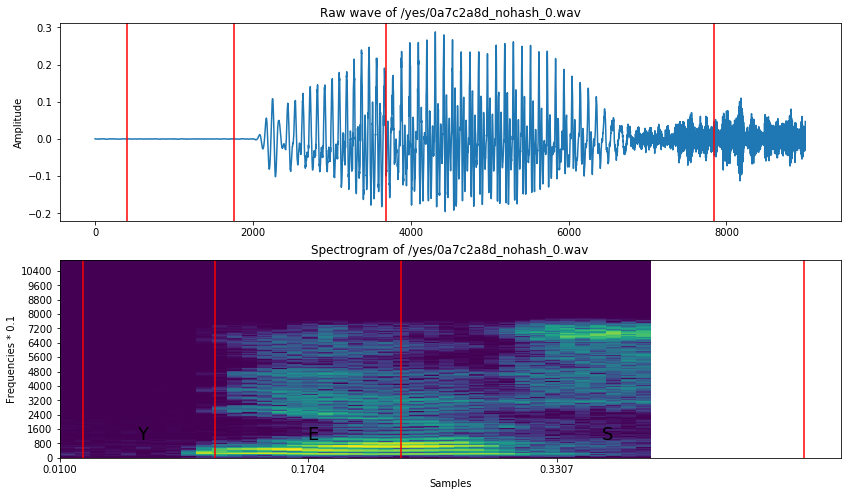

In [44]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)


fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])

ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5. Resampling - dimensionality reduction
<a id="resampl"></a> 

Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, [the most speech related frequencies are presented in smaller band](https://en.wikipedia.org/wiki/Voice_frequency). That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform). Definition:


"빠른 Fourier 변환 (FFT)"은 오디오 및 음향 측정 분야에서 중요한 측정 방법 입니다. 신호를 개별 스펙트럼 구성 요소로 변환하여 신호에 대한 주파수 정보를 제공 합니다. FFT는 기계 또는 시스템의 결함 분석, 품질 관리 및 상태 모니터링에 사용 됩니다. 이번에 제공하는 내용은 FFT가 작동하는 방법, 관련 매개 변수 및 측정 결과에 미치는 영향에 대해 설명 합니다.

엄밀히 말하면 FFT는 "Discrete Fourier Transformation"(DFT) 구현을 위한 최적화된 알고리즘 입니다. 신호는 일정 시간 동안 샘플링되어 주파수 성분으로 나뉩니다. 이러한 구성 요소는 각각 고유한 진폭 및 위상을 갖는 개별 주파수에서 단일 정현파(사인파) 입니다. 이 변환은 다음 다이어그램에 설명되어 있습니다. 측정된 기간 동안 신호에는 3가지 별개의 주된 주파수가 포함 됩니다. 

https://www.nti-audio.com/ko/%EB%89%B4-%EC%8A%A4/fft%EC%97%90-%EA%B4%80%ED%95%9C-%EB%AA%87-%EA%B0%80%EC%A7%80-%EC%82%AC%ED%95%AD%EC%9D%84-%EC%A0%95%EB%A6%AC%ED%95%B4-%EB%B4%85%EC%8B%9C%EB%8B%A4

In [93]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [45]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [50]:
ipd.Audio(samples, rate=sample_rate)

<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRiR9AABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YQB9AAAAAPn/5v/3/x8AEwAAAO3/9/8EAPT/9//w/wQAAgAEABMA7f/5//f/DAD8/+T/GAD+/+3//v8QABwABwDr//7/FQD+/xUAEwAAAAQA6P8MAAIA6P8MAAAADADt/wIAJgDh/+H/2v/+/zcABAAHAAAA4f8EAPf/3/8HAAAAGAAoAO3//v/w/wQAIQD3/wAA9/8AABAA9//5/xAAFQAVAAkA8v/+//7/EAACANX/9/8HAB8ADgDt/wQA6P8EAPT/3//3/+H/DgD8/wkABAD0/zcA8v8OABUA8P8oAPT/8v/3/9j/GgAYAPT/9//k/wkAEADo//D//P8QABwA/P/5/wQA+f8YAPT/8P8cAO3/AAD3/+T/DAD8/xwAEwDk//7/9//5/wQA8v/+//n/+f8EAOv/9P8JAAIAAAAAAAIA7f/t/wAAAAAAAP7/DgAaAAwADAAAAAwAJgAQAAwA/P/3/wwAAAAQABUA/v8TAAkA+f8MAPf/AgAMAO3/EAACANX/7f/8/xwAGAD0/wAA+f/5/wwADAAEAP7/AgD5/9j/9P8EAP7/AgAEABoA8v/h//L//P/8/+b/+f8MAAIA+f/c/+b/DADy/+H//P8CAPD/2P/r//T/AAAYAAcA9P/r/+H/AgAQAPT/BwDw//n/FQD8/wwA+f/3/xUADAAVAAkA/P8JAAAABwAHAPz/CQAAAAcABADy/wQABAAEAA4AAAAAAAIA9P/8/wQAAAAJAPn//P8HAPL/BAAJAOv/8P/r//f/BAD+/wcADAACAPf/8v/0/+v/5P/+/xUAGAD+/+b/5v/3/xUADgAJAAcA7f/t/wQADgACAAkABAD+/wkABAD0//n/EAAkABMAAAAAAAAAAgD3//z/AgD+/wIA9//w/wQADgACAP7/BwAMAAkADgDy/+H/9P/y/wQABwDy/wQADgACAPf/+f8JAAIA/v8CAP7/CQAEAP7/CQACAAcA+f/8/y0AIQD8/+v/6/8OABAABAAhACYAHwDy/+b/EwAHAAQACQDw/wAA+f/w/wQA3//r/xAABwAOAPn/8P/+/wAA/v8JAAcA9P/0/+v/6/8HAAIAAgDw/+H/BAAMABMACQD5/xMAGAAHAO3/5P/8/wkACQAMAAQA/v8OABoABwDt/+T//P/8/9r/1f/V/9//BAD+/+3/9P/3/wwA/v/Y/+v//v8JAPL/6P/8/9j/+f8TAPf//v8AAAQADAACAAAABwACAAIA9//8/wwAAAAQABAADgAcAAkAEwAaAAIABwAEAAIAGgD3/wkAIQAAABAABwAEAAcA/v8CAP7/AAAEAB8AHAAEAPf/8P8HAAQABAAYABUAGAAVABAA9P/f/wwAEwD+/wAA/v8CAPT//P8JAAIAAAD3//7/4f/h/wkABwAMAAIA/v8CAPf//P8MAPz/6P/m//f/DgD5/+b/+f8CAP7/BAAYAP7/6P/a/+T/JAAwABwA9//f//z/EwD+//f/AAAHAPf/0//r/wAA/v8JAAIAAAD8/+b//P/8/+T/AAAVABUAAADV//z/DADm//7/+f/t/wAA9//r/9r/5v8JAAwACQAMAPn/8P/0//z/BADt/+H//P8CAAAAAAAAAAAAAAAHABUABwD0//z/BwATABoABAAAAPn/5v/8/wIAAAD+/xAAEwD3//7/+f/8/wIA/v8JAAwAAgAAAAcACQAYAAAA7f/3/+b/+f8JAAQA9//w//7/AAAAAPf/AgAOAAIAAAACAPT//P/5/+3/DgAYABgABwDr/+H/9/8TABgAGgACABAAAgDY//T/EAAhABgA9//w/wcA/v/w//T/CQAoABoADgACAPT/AAAaABUAEAD8/9j/9P/y//L/DgAAAAkABAD0//T/+f8JAAwAAgD3//D/AAAAAP7/AgD0//n/AgD+/wIA9//8/wIAAAACAPD/5P/w//z/AgAAAP7/EwAJAP7/8v/h//z/AgD+/wkAAAAHAAkA6P/3/wwAEwAaAAQA/v8EACEAFQD+/wIA/P8QAAwA9P/8/wkAAgD+/wkABAD3/+b/9/8JAAwABADr//f/AgD+/wIA9P/5/wwACQAMAPn/8v/3//L//v8CAPf/6P/t/wQAFQAOAAIA/v8QABoADAATABoAFQAVABUADgACAPn//P8JAA4A9/8AABAABwAVABAAAAAJAAIABwD+/+b/7f/8/wAA9//8/wwA+f/w/wcADgAEAPT//v/5/+3/AgDt/+T/6P/t/wcADgACAPf//P8JAAkABAD3//L//P8MAAwAAgD3/+j/9/8HAOv/5v/w//z/DADw//T/BAD+/wwA+f/m//n/CQACAPf/8v/y//7/AAAHABMAEAACAPf/9P/a/+j/AAAOABwADAAMAPn/8P/0//n/AgAHAAQAAAAAAAAACQAOAPn/8P/+/wAAAAAAAAIA9//y//7/AAAHAAQA/v8AAAkA/P/w//f/6P/m/+3/BAAOAPf/8P8HAAIADgAfAAIABADk/+H/GAD+/+3/BwAQACsAIQACAPn/5v8AABgAFQAHAP7/AgD3/+b/9/8CAAQAEAAAAAIA9//+/zAAGAAHAAcA/P8MAPn/+f8JAAkABAD+/wkAAgD+/wcAEwAJAOj/AAATAPf/+f8QABoABwD0//L//v8CAP7/AgD3/+v/2P/r//z/2P/0/wIADAAfAAQA8P/V/+b/HAAVAAIA9//3/wwA+f/5/wQA9P/8/wwAAgACAPf//P/5/+3/BwAEAP7/AAAAAAAAAAAAAAcABAD0//z/AAAEAAwAAAAAAP7/EAAJAPT/7f/h//z/AAAAAAIA/P8TAAcADgATAAIAIQAMAPz/DAACAPn/3P/c/xAAEAAJAAQA/P8MAPD/9P8OAPf//P8CAP7/AgD3/+j/5v/y//T/+f8MAAQA9P/+//n/9/8JAAkADAD8/+b/8v/y/wQAEAAEACEAEADk/wIADAAQABwAAgAHAAQABAAEAP7/AgD+/wkAAgAEABoABAACABUADAAEAOv/9/8TABUAEwDk/9r//v8AAAAAAAAAAAkACQAVAP7/7f/0//D/BwD8//f/DgD5//L//v8EABUAEAD3//z/AgAAAAAAAAAAAP7/BwAMAAQA9//w/wAAAAAHAAIABAAQAPf/+f8CAP7/BwAMAAQA9P/r/+b/+f8MAAcAEADy/+v/BADr/+3/AAAHABUABAD+//n/6P/m/+b/7f8HAA4ADAAEAPT//v/3//z/+f/5/wkADAAHAPT//v/5//D/9P/y//7/AAAAAAAAAAAAAAAAAAAAAAcAFQAJAO3/5P/5/xAAGAAYABUAGgD3/9P/9P8CAAAA9//3/xMAGAAHAPf/6P/w//z/EAAaAAcA9P/o/+3//v8HAA4ADAACAAcABAD+/wAABwAOAAIAAAAAAAAAAAAJAAQA/P8MAPz/8P8AAAAABwAMAAIAAAAHAA4AAgD3//L/9P/8/wIA+f/m/wkAHAAEAPn/6P/t/wwAGgAOAPn/+f8MAAIA9//y//T/8v/8/wwA+f/5/wIABAAYAAwAGAD3/9D/5v/t/wQADgAHABUACQD0//z/AgD3//L/BAAMABMACQD0//f/6//t/wcABAD+/wAAAAACAAAABwAOAAIAAAD5/+j/6P/w/wQABAD8/wwA/P/w//T//P8JAAQA9//o/+T/8P/8/xAAEAAAAAcADAAEAPf/8v/y//z/CQAMAAQA9P/5/wkAAgAEAA4AAAAAAPf/+f8MAAIABwAMABAAHAD8/+3//v8AAAIA+f/y//T//P8AAAAAAAAAAPf/8v/8/wcABwDr//n/AgD8/wwA/P/o/+b/9/8MAPf/8P/0/+v/7f8AAP7/BAAY

In [51]:
ipd.Audio(resampled, rate=new_sample_rate)

<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRqQ+AABXQVZFZm10IBAAAAABAAEAQB8AAIA+AAACABAAZGF0YYA+AAD8/+z/FAACAPL/AADv/wwAAAD6//z//v/9//7/FgD3/wUAEwADAP3/+/8BAP//BwD4/9r/JgD///f/8v/3/xwAAQD0/xQA9f8GAP3/CQAZAPX/CAD5/+z/HQD3//r/8//n/wAAAgAJABEABAAPAPD/8f8VAOn/BQD1//r/GAD1/woA+/8DAPn/8f8LAAsA7v8BAPb////2//r/AwACAPH/+/8AAAwAEwACAB4ACAD7/woADQALAAIAAAAAAAUA5v/+/xkA8P8GAAMACQDr//P///8OAPf/7f/4//X/CQDg//3/6//+/9//9P8RAPb/6f8LAPf///8JAPv/CgATAAAABgADAAMABQD8/wUACAAAAPr/AAADAPz///8AAOr/9/8DAAgA+f/w/+n/FAAAAOP/EAALAPP//f8OAP//CgD0/xIAFQD9/wAA+f8EAPT/AgAGAAIAEQDz/+r/AwD8/woA+f8EAAAAAgADAAUAAAAGACQA5P8KAA0AKwD3/wEACwD4//v/8v/v/xEA+f/5/wMABADv//D/CQDs//z/EwAAABgA7f/3/xAAAAAQAAcA5//6/8v/6v/8//D/BQDk//r//f/j//v/AAD//wkAAQAEAPr/AwAMABQAEwASAAMACQAHABAADAAEAAMA/P8MABoA9v/+/w0AFQAbAPH/AAAJAPv//f8AAAQA7//s/woABQD7/wAA/P/m/wYA7f///wcABgDS/x4AGwDm/woA+f8DAN//+f8HAP7/8//y//7/FQDl/wEA8f/7//P/4P/+/xMA9v/4//v/6////wIA/P8NAAUA+v8UAA0A8f/5/wAADQAAAPn///8IAAQABQAQAPT/7P8GAPf/+v///wAACAD8//n/9v8aAAUA4f8TABMACwDl/xAAFQDz/wAA8f8lAA0A+v8SABEA4//1/wAACwD1//3/CwD3//r/AgD3/wAA/v/7/wQA8P/s/wIAAQAPAOr/9/8CAAYAAAD0/xoABQAKABgA+f8OAPv/AwACAAQA6f8JAAAA8/8EAPX/CAAHAPT/9f8BAOj/BAAPAAEAFgASABkAFAACAP3/CgD9/xQACwAGAAMA7v/2///////7/wgA/v/1//n/5P/y/wwA+f8GAAQA8f8LAAEA7v/9/+X////5//z/BwDr/wYA9//0/wEAEQAGAOr/5/8SABIA+v/y/wIABQD+/wsA/f/3/wMA/f/1/wIAAwABAP//7v/n/wEA///5/xUACwDq/wAA+/8RACgA6v8EABIABADy//T/CAAHAPf/IQAKAAMA/f8EAAYAAgACAA0A+P8FAP7/FwD2//v/AwD1/+D/7v/r/xUACADZ/w8ABwD3/wQA9v8CAAIA///y/wEAAAABAP//BwD5/wAABwD//woA+v/k/wQA+/8OAAgAFgAJAAkA8P/n/xMAAwD///r/AAD9/wAA6v/s/wAAAwD4//z/DQD6/+v/AgAUAAoA9f8bAAYABwAAAAIAAAANAAgADwAAAPX/HwDo//P/BAD//xEA///v//7/AAD+//j/FQD9/wAAAQD//wcABADy/wQAAwAIAPj/BAAIAPn/5f8NAAIA9v/w//z/EAD+/+z/5P8DAA4A+P/8//b/CAADAPn/9P/0/wEA//8BAP7/CwAHAOT/EAAZABMA3v8CAPX/DwAKAOj//v8YAPT/7f8JAAoABQAAAAYABwD9/wUAAgADAPX/AwAIAAIACwD4//T/AADw/xgA8//y/xgA/v8DAPz/7f8AAP3/AAARAA8A2v/x/wsADwD8//3/9v8OAAkA7v/0/wUA/v8CAAUACQDz/+r//v8GAPv/8/8GAPn/4f8BAAwABgAEAPD//f8MAPj/AwAGAAYA9v8HAAMAGAD///f/AgDy//v/AQD+//T/BAD3//v/CADo//j//v/s//L/AAAOAAkABQDv/wAAGwD+/wYADgAGAAIAEQD6/wwAAQAPABcABwDx/wkADwD7//n/9P8ZAAsA5//u//r/8v/2//z/+//7/wwA/v/8/wIADQACABAACwD1/wQAAgAAAPn/+f8CAP//6f/l/wsA/P8GAPf///8CAP7/7v/3/+L/+P8HAPb/+/8BABIABwD0//v/7f/5/wYA5v8EAAMAAQD1/wMAEAD4/wMA/f8IAAsA+P///xUA7P8LAAwAAQAJAPb/+/8SAAsAAAD9/x8ADwDr/+v////8/+b/2/8GAAMA9/8IAPb/9f/t/+j/BAD8/wsAFgALAP//AwAXABIA4v/z/wQAAAD//wUAAQARAPP/AwALAP7/8v/8/wEABQAAAAMABADy/wAA8P/4//n/BAAAAAwAAAANAP7/+v8YAO//DAD6/wQABgAWAPz/EgAKAP7/9f8iANf/6v9hAPL/8P8HAAsA3P8DAA8A+f/6/wgADgD2/+b/FgAWABYA6f8BAAcA6f////f/DwD6/+3/+v/4//v/+v/4//H/EQD7//3//P8DAAMACQAAAAMAAAAKAPH/6f8CAAkA9//x/wAABwDr/+z/AAAfACEAAgD9/wsADAAEAAsADQAmAAMACgADAP/////6/wMA9P/+//b/7//8//b/CgAIAAoAAwDx//P////6/xgABADl/wgA6/8AAAoAAAAEAO7/7/8OAAcA9f/u/w8ABgD8//7////7////9P/+//L/DQAEAAAAAAD//wMAAwATAA8ABAAFAPj/BwAAAAIA/f8GAAAACQD1//7/BAAGAAYA/v8DAPf/AAAOAAAABwD8/xkAGQD+/+3/9P///wAA8v8QAAIA5v/2////DAAAAPn/BAACAAAABAANAAAA8f/4/wkAAwDw//v/AwAFAPf/AQD3/+T/5v/1/wIA/f/t/+r/CgADAAAAAAAPAAAADAAcAAgABgAAAPT/EAAAAP3///8BAP7/AgACAAoA9f/9//7/BQD3//X/AQABAPX/7/8CAAQAAQAAAAAABwASAAMA6v8FABIABgAGAAAACQD+/wYA9v8JAAIA+v8EAPP/9//+/+b/9v8BAAAAAAAAAAAACgAEAPP/8/8LAAcABQAGAA4AAgAGAPv/AAAIAAAABQAAAP//AQAAAAwAAAAZAPr/BAAEAAwABQAAAO//9f8KAPr/5v/0/wAA/P8EAPr/AAABAPn/EQAlAAMA+/8CAAMA/P/2//3/8/8CAPX//f/2//z/DwDz/wQA+//w//b/CwAQAAMA9//+//j/8v/3/wQA6v/8//T/9v8BAAAA//8NAAUACQADAAIACQAMAAcABAAVABgA9f/+//X/9v8AAPj/AwAMAAMA5f/+/wUA//8OAAIAAAD5/wMA8P/9/wYA/v8BAP//AAD+//H//f/5/+b/AgDm//j/+P/i/+n/BAAAAPH/5v8EAAUAAAD9/wgABQD9/wEAAAANAAgACAAGAAIA/v8CAP7/AwACAAAA//8BAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAD0/+r/+v/8//z/9//r/+T//f8AAAAABAANAPb/+/8AAAAAAAD///n/AQD+/wMACQD5/+D/8f8EAA0A8//4/wIAAAD+/woAFwADAAAADAD+/wcA+f8BAP7/CQD4/wgABwD0/wAACwD9//3/AAAFAP//+f8DAAAAAQD+/wUACQD9/wIA//8BAP//AgD4//H//P////L/AwD+//3/AgAEAP//AQAAAAAAAAAAAAcAGAD3/wIAAwAEAP7/BwAGAPn/+v8CAP7/AgAHAAEA//8AAPL//P8AAAAAAAAAAAAAAAAAAPv/AAAAAPP/AQD+/wMA9P///xUADwADAAIAAAAAAAwABgD//wYA/f/+/+z/BQD8/woA/P8LAAAA/P/6////AAAA

Almost no difference!

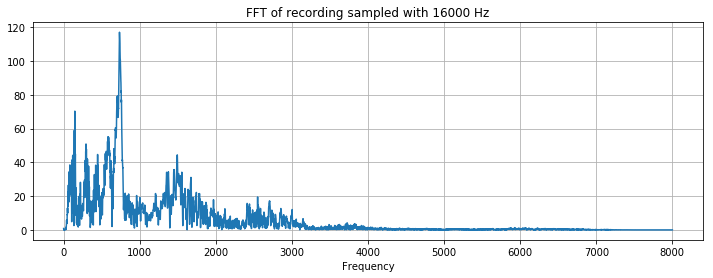

In [48]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

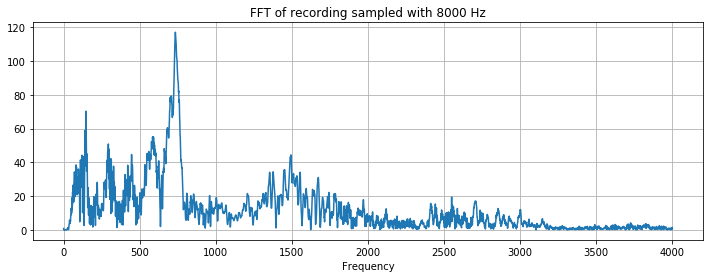

In [49]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice!

## 1.6. Features extraction steps
<a id="featuresextractionsteps"></a> 

I would propose the feature extraction algorithm like that:
1. Resampling
2. *VAD*
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or *MFCC*, or *PLP*)
5. Features normalization with *mean* and *std*
6. Stacking of a given number of frames to get temporal information

It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.


# 2. Dataset investigation
<a id="investigations"></a> 

Some usuall investgation of dataset.

## 2.1. Number of records
<a id="numberoffiles"></a> 


In [124]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 2


In [129]:
# Calculate
number_of_recordings = []
# for direct in dirs:
waves = [f for f in os.listdir(join(train_audio_path)) if f.endswith('.MP3')]
number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridis', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))


<div id="5d1f6504-35cf-481c-bc71-facd0df8c5a4" style="height: 525px; width: 100%;" class="plotly-graph-div"></div><script type="text/javascript">require(["plotly"], function(Plotly) { window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("5d1f6504-35cf-481c-bc71-facd0df8c5a4", [{"marker": {"color": [2], "colorscale": "Viridis", "showscale": true}, "x": ["test", "train"], "y": [2], "type": "bar", "uid": "28debda6-cf85-11e8-9db9-448a5b3733a4"}], {"title": "Number of recordings in given label", "xaxis": {"title": "Words"}, "yaxis": {"title": "Number of recordings"}}, {"showLink": true, "linkText": "Export to plot.ly"})});</script>

Dataset is balanced except of background_noise, but that's the different thing.

In [130]:
waves

['036.MP3', '001.MP3']

## 2.2. Deeper into recordings
<a id="deeper"></a> 

There's a very important fact. Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.

Nevertheless,** it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets.**
Just take a look and listen to this two examlpes:

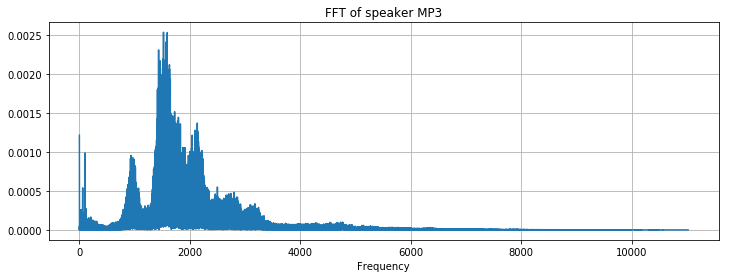

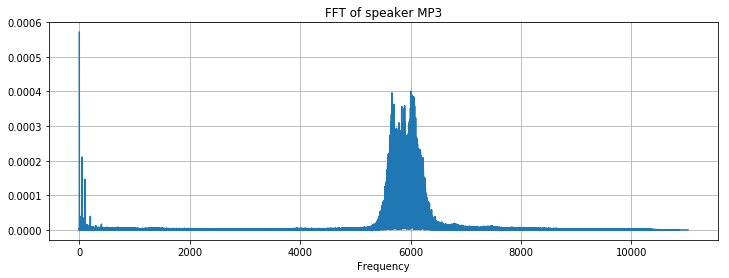

In [100]:
filenames = ['001.MP3', '036.MP3']
for filename in filenames:
    samples, sample_rate = librosa.load(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

Even better to listen:

In [63]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRgZdAABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YeJcAADH/6z/yf+u/7D/tv/F/9n/tv+2/7T/m/+o/7P/xf/P/6//n/+8/7H/ff+5//b/w/+m/5r/nv/L/83/tP+p/6H/n/+1/7L/lf+w/9b/3//p/8n/rP+8/7T/zf+//6v/vP+8/9D/sf+k/8P/0v/H/8H/zv/F/7v/kv+o/9z/tv/C/6P/kP+8/6n/tP+V/4L/qf/V/9z/kP+S/9L/uP+i/6r/wf/j/8P/rf+h/7n/tP+c/6//mv+4/8v/yP+1/4H/jv+l/63/rv+v/6T/sv/G/6j/l/+T/4z/qv+Q/2j/jf+q/8b/u/+X/5T/qP+7/7L/of+D/4n/tf/C/6z/j/+s/67/nf++/7j/nf+Q/7f/3//H/7r/oP+f/6//pP+u/7b/wf+p/6v/r/+h/67/sf+x/77/xP+t/4b/o/+l/5P/1v+//7X/tf+3/8T/jv+Z/7//4f+s/37/wv/S/8T/tP+o/5X/mf/N/6T/lP/Z/3//P//m/28AHQDF/5j/P/9O/9n/lgAQALb+P/97ALD/B/+s/zAATABr/+L+BgCRAET/1f6G/wMAPgC1/z3/zf/w/0z/a//C/5n/T/+K/wkA2P9i/33/rf9U/1b/lv/B/xkAlv/k/jb/uf/Q/3r/Z//t/0wAv//X/sj+iv82AP//cf+J/xQACABi/zP/o//A/47/jP+Z/7T/vf+O/2v/mf+5/5j/kv/L/6z/TP9d/6z/vP+R/4n/q//D/6X/Xv9V/6H/8//a/47/if+t/6j/gv97/5T/pf+E/4P/n/+Z/3n/kf+g/4X/mv+A/23/df+M/7z/tP+k/4v/ff+j/5H/hf+//7//mP91/4z/tf+B/27/rP+s/3X/gv+q/5H/lf/b/7D/Yv+V/8L/qP9//3z/iv+f/6r/oP+Q/4j/lf+p/5r/jv+2/5v/dP+V/7z/wf+B/2//i/+H/6v/jP9g/2f/m/+7/4r/hP9+/57/qf+J/4j/ZP9s/5P/jv9v/1L/Wf9a/1r/gf9+/2X/p/+q/2j/S/9O/3D/Yv94/53/gf9M/2L/gv+Q/7P/if9v/4r/h/9R/0f/e/+J/3j/df9y/2v/ev+E/2f/lP+//4j/d/9x/4X/nv92/2//hf+g/4D/bf+h/5//if+a/5n/Y/+L/6v/eP95/2//YP+d/8X/hf9V/5P/n/9q/3D/ef9r/3n/h/94/1z/hf+K/23/iP+h/8b/hf9Z/2v/g/+G/2//ev+M/6H/hv9n/43/of9e/3//sf+n/3f/WP+X/5n/pf+O/2P/j/+q/5b/jv+F/5H/bv9O/6j/lP+M/7f/uP+d/3P/nv+k/5H/mv+W/4z/mv+5/5L/gP+Q/5X/kP9//5f/jv+c/6L/hP+w/7b/nP+h/5X/kf+L/4v/fv+A/6P/j/+c/67/kv98/4f/lf+M/4v/f/+U/63/mf92/37/m/+g/5z/gv+N/5b/gf98/3//mf/O/8T/if98/4j/ov+N/5n/n/+l/5//Y/9+/4r/nP+E/4D/s/+l/4b/Xv93/33/Y/9w/3r/e/+Q/5X/cv+H/4n/bv+N/6n/jv9//4j/hf9u/2L/Zv97/33/ef+Z/4b/cP9+/4f/if90/3b/pv+L/2n/c/98/4j/cP96/2j/Vf9t/2r/Zf+E/2f/Uf9g/2z/gv9V/1P/WP9i/4f/XP9K/2//gP9w/0D/Sf9x/37/a/9q/3z/WP9e/2f/Qf9f/3//WP9H/0P/Zv9m/1P/Yf95/33/Kf9T/5b/bf9P/0j/Vv9A/1H/ZP9u/4L/Vf9R/2v/gv+C/1//Yf9//3j/Tv9J/33/jv9l/13/af9o/13/Y/9p/2b/hP96/1D/cf9w/13/hP+T/2f/R/95/3//Zf9a/0b/aP9+/3z/iP+I/3r/gv+B/3v/gv+L/37/f/+N/4T/jv9r/2j/Zv9l/3X/df9//1P/ZP9r/2r/cf97/4r/Xv9//6z/aP86/4z/mf9X/2f/k/95/2z/gv9d/5P/k/9p/43/iP+M/2//Xf91/6L/kf9r/4D/hP+Q/5H/gv+j/7X/cf96/7L/t/+k/3v/jv+N/6b/uP+Z/63/qP+U/4j/kf/A/7v/iv99/7f/1f+D/33/qf+q/8H/uP+l/3X/kv+0/4//p/+p/7L/jv93/5H/rP+5/5H/j/+n/6z/m/+c/6D/lf9+/5v/uP+N/47/dv9r/57/t/+y/5n/kf+Z/5L/hP+O/67/lv9y/2z/a/+F/4r/iP+W/43/hv+X/4L/gP+c/3T/hP90/0//sP/R/6H/i/+D/4T/qv+e/3n/dP+F/47/Xv9j/3z/if+S/5f/gv+U/5T/cP+k/7D/gf9D/3z/tv+A/2//f/+e/37/aP+F/33/f/+R/7X/g/85/2r/fv9o/1v/W/9s/2P/b/+G/37/d/+G/4j/V/9f/3z/bv9j/1b/fP+D/1r/T/9Y/2T/Y/9Z/2H/hv94/3X/Zf9q/2v/PP9t/4r/k/9l/0//d/9Z/2v/c/97/3r/QP9c/3T/W/9d/0b/Of9Y/3P/dv9s/1v/Zf+P/6P/c/9S/2n/bf+H/3z/T/9d/3n/W/9i/3P/bv+Q/3n/SP9Q/4D/gv9o/1v/Wv9o/2n/Y/9l/2n/Vf9s/3D/af9p/2P/fP9//3n/WP9r/4r/Z/9Z/2H/Xv9z/3X/fv+C/13/Yf93/3X/e/98/3L/VP9j/4r/cP9p/2b/dP94/4L/kf9h/2P/bv+H/5T/fP+B/3z/f/+E/3f/k/+2/3X/a/+Z/4f/cf9m/4P/if99/4X/lf+j/33/Uv92/7D/qP+S/47/jP9z/3P/oP+x/4T/W/9z/5H/hv9f/2f/fv+O/2z/Vf92/2b/X/+E/5v/mv+K/3j/lP+k/5j/iv9t/5b/0P/H/63/qv/A/8L/qv+g/7n/yP+//63/j/+N/53/qv+8/8r/rf+F/5r/vP+4/53/kv+l/7b/iv96/77/tf+b/6D/jv+m/6j/kf+U/4j/hP+T/63/q/+N/2r/kP+r/4v/lf+b/73/qf+f/5n/gf+g/47/if+j/7X/r/+a/4z/ev+J/4X/mf/G/6P/e/+O/5n/bv9h/4r/oP+r/4H/Uf+P/6T/g/99/3v/kv+I/3L/av91/6L/nv+K/4b/b/9h/2b/gv+A/1P/Yv95/4L/d/9o/3//jf+I/0n/Tf+M/33/Zf9k/3v/i/+C/3f/df9d/2r/jf9z/2r/Z/9w/5D/h/9k/4L/iv9x/3z/dP+G/4P/bP+F/2P/SP+G/3X/Xv+d/4b/Y/+J/5L/X/9J/4b/fP9U/3X/hf9y/1T/cf+Z/37/fv+K/4j/bf9l/6L/gf9n/4L/ff+Q/3n/f/+S/2v/Uv9z/4f/Rf9W/3L/hP+G/1T/iv9z/0H/ef+J/1P/R/9o/33/v/++/4f/Xf9m/5X/g/+A/3X/R/+a/9n/iv+b/6P/r/+4/0D/Bv8//5D/q/9g/1T/uf/q/83/jv9p/2L/d/+i/6b/h/9+/6j/zP+S/5v/t/+h/6r/pP95/17/l//L/7P/jP+D/6H/tP+a/3z/Zv+l/9L/rv+F/2H/hP+l/5j/kv+W/5n/0v/t/5n/Yf+N/7D/n/+R/4b/uf/k/6v/df+b/8L/i/9r/2v/lv+8/2z/kP+w/3z/mv+z/6z/jv+H/5T/pf+e/4//hf90/4//2v+o/3H/y//g/7T/gv+K/6H/o/+6/6T/iv+i/73/wf/H/5//if+N/5b/lP+K/8b/pv+B/7b/w/+W/4D/pf+o/4j/bf+O/53/nP+c/3v/mP+j/23/dP+R/5v/f/9s/5//pv+V/37/d/+K/4f/nP+c/4D/cf92/5v/y/+R/1b/kv+r/47/e/9n/3D/j/+H/2j/Y/+C/4f/rP/N/5r/W/

In [64]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 137b3f4


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRiR9AABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YQB9AAAAAAIAAgACAAIAAgACAP//AQAAAP7/////////AAABAAIAAQD//wIAAgD///////////////////////////////////////8CAAIAAgACAAIAAgACAAIAAgACAAIAAQACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgADAAIAAgACAAIAAgACAAIAAgACAP7//v/9///////+/////////////////wIAAgD//wIAAAD/////////////////////////////////////AQD///////8CAAIAAgACAAIAAgACAAMAAgAAAAIA/////wIA/v8BAAIA/////wIAAgACAP///////////////////v///wAAAAAAAP//////////AgACAAEA//////7/AQACAP7//v/+////AAAAAAEA//8BAAIAAQABAAIAAQAAAAIAAwACAAIAAgACAAIAAgACAAIAAwACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAEAAgACAAEAAwACAAEAAQABAP7///8BAP//AQACAAEA/v/8//3//f/8//3//f/8//z//P/9//3//f8BAAEA/f/9//z//P/9//z//v8CAPz//P8BAP3//P8AAAEAAAACAAEAAQACAAEAAgACAAIAAQACAAIAAQACAAIAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAgD//wIAAwACAAEAAgACAP///v/////////+//////////////////7///////////////7//f/+//7////+/////////////v8AAP////8BAAIAAgACAAMAAgACAAIAAgACAAMAAgADAAIAAQAAAP//AQD///////////////////7//////////////wIAAwACAAMAAwACAAEAAAACAAIA//8AAAEA/////////////////////////////////////wEAAQACAAMAAgACAAIAAgACAAIAAgACAAIAAwADAAIAAgADAAIAAgADAAIAAgADAAIAAgABAAIAAgAAAAIAAAD/////AgADAAAAAAD//////v///wEA////////////////AAABAP////8CAAIAAAD//////v///wEA/////////v////////8BAAIAAgACAAIAAgACAAIAAgACAAIAAgABAAIAAgACAAEAAQACAAIAAQABAAEAAQD///7//v/+//7//////////////wAA///+//7//v////////8BAP///v/+//7/////////AgACAP7/AgACAP///////wEA//8AAAIAAQACAAEAAgACAAIAAgACAAIAAgADAAIAAgACAAIAAQAAAAIAAgACAAEA/////////////wAA///+////AAD///7//P///wAA/f8AAAIAAAD+//z//f/9//3//v/9//3//f/+//3//f/+//3//f/9/wEAAQD///7//f8AAP7/AAAAAP3/AAABAAAA/////wEAAgACAAIAAgACAAIAAQACAAAA/////wIA///+/wEAAQD///7/AgACAP//AgACAAEAAQD///7//v8AAAIAAgD+/wAAAgACAP////8CAAMAAgACAAIAAgD/////AwACAP//AwADAAAA///+////AAAAAP//////////////////AwADAAAAAAADAAMAAgACAAIAAgABAAMAAwACAAAA//8CAAIA//8AAAEAAwACAP//AAACAP///////wAA////////////////////////AgACAP7///8CAAIAAQACAAIAAgABAP//AQAAAP////////7//P/9//7//f/9//3//v/9//v//f/9//3//f/9//7///8CAAMAAgD+//7/AgACAP7/AgACAP7//f/+/wIA////////AwACAP7/AAD///3///8CAAIA/////wEAAgD/////AQD+////AgACAP////8CAAEAAAD/////////////////////AAACAAIA/////wEAAAAAAAAA///////////+/////v///////////wAA/v/+//7//v8AAP7//v////7//v///////////////v//////AAABAAEAAQABAAEAAAABAAIAAgABAAEAAQABAAIA///+/wEA/v/+/wIAAgACAAIAAgACAAIAAQACAAMAAgACAAIAAgADAAEAAgACAAIAAgACAAIAAgACAAIAAgACAAIAAQABAAIAAgD+////AgACAP///////wEA/////wIA/////wMAAgD+//3//v/9//3//f/9//3//f/9//3//f/8//z//f8CAAMAAgACAAIAAgACAAIAAQACAAIAAgACAAEAAgACAAIAAgACAAIAAgACAAEAAgACAAIAAgACAAMAAgACAAMAAgD//////////////////////////////////////////////v////7//v/////////////////+//7//////////////////v///////////////////////////////////////////wIAAAD//////v///////////////v8AAAEAAAABAAIAAgACAAIAAgACAAAAAgACAAIAAgACAAEA/v///wIAAgD/////AQD///////////////////////////7////+//3//f/9//3//f/9/wIAAgD+/wEAAQD//wIAAQACAAIA//8CAAMAAgACAAIAAgACAAMAAwACAAIAAwACAP3///8AAAIAAgACAAIA/////wIAAgACAAIAAgD/////AgACAAIAAgACAAEAAgACAAEAAgACAAIAAgACAAEAAgACAAIAAwACAAIAAgD/////////////////////AQABAAIAAQD//wIAAQACAAIAAQABAAEAAQABAAEAAQABAAEAAQACAAIAAgACAAIAAgACAP////////7///8CAAIAAgACAAEAAQACAAIAAgACAAEAAgACAAIAAgADAAIAAgACAAIAAgADAAIAAgACAAIAAwACAAIAAwADAAIAAgD/////AgACAAIAAgACAP/////+////AQD////////+/////v///////v/9//3//f/9//3//f/9//3//P/8//3//f/9//3//f/9//3//f/9//7//f/9//3//f/9//3//f/9//7//f/+////AAD/////////////AAACAAAAAQACAAIAAwACAP////8CAAIAAgADAAIAAQD//////////////v///////v///////v///wEAAQABAP////8BAAIAAgABAP////8CAAIAAgACAAAA/////wEAAgACAAAA//////////////7///////////////7/AAACAAIAAgAAAP//AAABAAIAAgACAAMAAgACAAIAAgACAAIAAwACAAIAAwACAAIAAgACAAIAAgACAAIAAgAAAAEAAgD+/wAAAQAAAAIAAwABAP//AQAAAP7///8CAAIAAgACAAIAAQD/////////////AAD+//7/AgD+//7////9////AAABAP7//v////7//v/9//7//f/9//3//f/8//7//f/+/wEA///8////AgD///7/AAD//////////////////////////////////////////////////wEAAgACAAIAAAD/////AAACAAIA//8AAAIAAgACAAIAAgADAAIAAgACAAEAAgACAAIAAgACAAIAAgACAAEAAQACAAEAAQD//////v8AAAEA/v/+/wEA/v///wIAAgACAAIA/////wEA//8CAAEA//8CAP7//v

There are also recordings with some weird silence (some compression?):


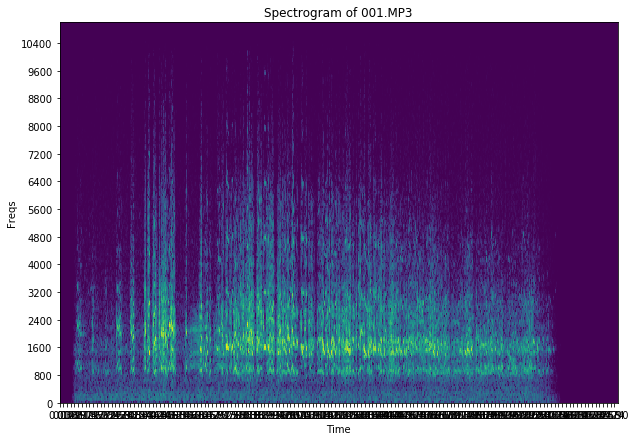

In [113]:
filename = '001.MP3'
samples, sample_rate = librosa.load(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

It means, that we have to prevent overfitting to the very specific acoustical environments.


## 2.3. Recordings length
<a id="len"></a> 

Find if all the files have 1 second duration:

In [131]:
filenames = ['001.MP3', '036.MP3']
num_of_shorter = 0
for filename in filenames:
    samples, sample_rate = librosa.load(str(train_audio_path) + filename)
    # samples, sample_rate= librosa.load(train_audio_path + direct + '/' + wav)
    if samples.shape[0] < sample_rate:
        num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

Number of recordings shorter than 1 second: 0


That's suprising, and there is a lot of them. We can pad them with zeros.

## 2.4. Mean spectrograms and FFT
<a id="meanspectrogramsandfft"></a> 

Let's plot mean FFT for every word

/home/admin-/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning:

Mean of empty slice.

/home/admin-/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



TypeError: Invalid dimensions for image data

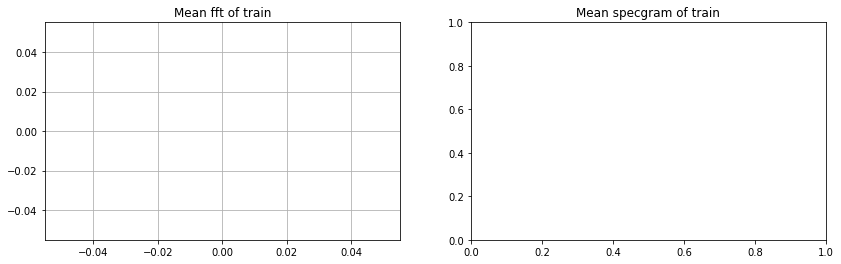

In [137]:
# for direct in dirs:
vals_all = []
spec_all = []
# 
#     waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.MP3')]

filenames = ['001.MP3', '036.MP3']
num_of_shorter = 0
for filename in filenames:
    samples, sample_rate = librosa.load(str(train_audio_path) + filename)
    if samples.shape[0] != 16000:
        continue
    xf, vals = custom_fft(samples, 16000)
    vals_all.append(vals)
    freqs, times, spec = log_specgram(samples, 16000)
    spec_all.append(spec)

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title('Mean fft of ' + direct)
plt.plot(np.mean(np.array(vals_all), axis=0))
plt.grid()
plt.subplot(122)
plt.title('Mean specgram of ' + direct)
plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower')
# plt.yticks(freqs[::16])
# plt.xticks(times[::16])
plt.show()

## 2.5. Gaussian Mixtures modeling
<a id="gmms"></a> 

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like *stop* and *up*... But wait, they are still distinguishable when we look at spectrograms! High frequencies are earlier than low at the beginning of *stop* (probably *s*).

That's why temporal component is also necessary. There is a [Kaldi](http://kaldi-asr.org/) library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with [Hidden Markov Models](https://github.com/danijel3/ASRDemos/blob/master/notebooks/HMM_FST.ipynb).

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use [Scikit-learn](http://scikit-learn.org/) for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6. Frequency components across the words
<a id="components"></a> 


In [120]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    filenames = ['001.MP3', '036.MP3']
    num_of_shorter = 0
    for filename in filenames:        
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.MP#')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

In [121]:
violinplot_frequency(dirs, 20)

ValueError: min() arg is an empty sequence

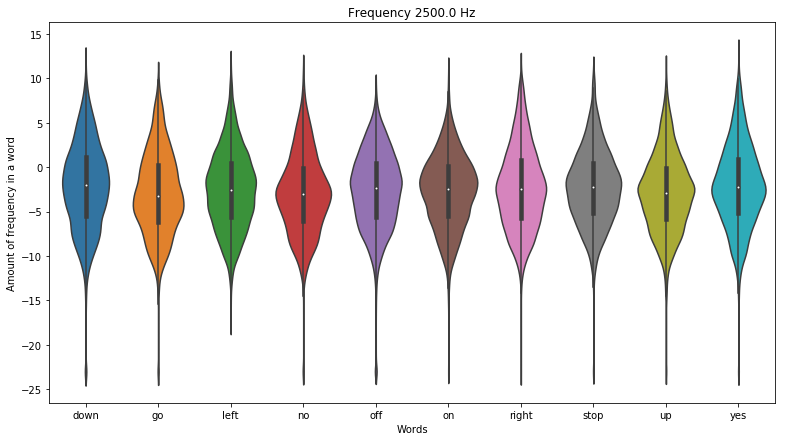

In [70]:
violinplot_frequency(dirs, 50)

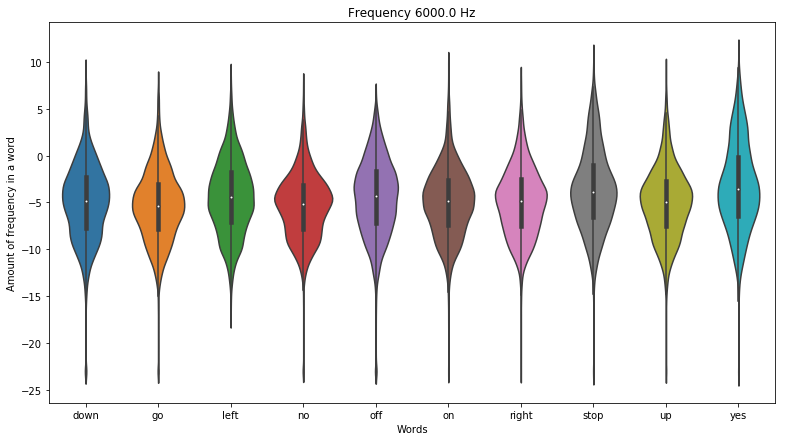

In [71]:
violinplot_frequency(dirs, 120)

## 2.7. Anomaly detection
<a id="anomaly"></a> 

We should check if there are any recordings that somehow stand out from the rest. We can lower the dimensionality of the dataset and interactively check for any anomaly.
We'll use PCA for dimensionality reduction:

In [72]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

/home/admin-/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




<div id="83854c56-c7bc-43d2-a060-d6c102fc3be4" style="height: 525px; width: 100%;" class="plotly-graph-div"></div><script type="text/javascript">require(["plotly"], function(Plotly) { window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("83854c56-c7bc-43d2-a060-d6c102fc3be4", [{"mode": "markers", "text": ["down/c08585c1_nohash_0.wav", "down/7257420c_nohash_1.wav", "down/3a182c98_nohash_2.wav", "down/4c77947d_nohash_1.wav", "down/9ff2d2f4_nohash_3.wav", "down/471a0925_nohash_4.wav", "down/c661be6e_nohash_1.wav", "down/030ec18b_nohash_1.wav", "down/016e2c6d_nohash_2.wav", "down/9785931e_nohash_0.wav", "down/b55a09be_nohash_1.wav", "down/a8cf01bc_nohash_0.wav", "down/8012c69d_nohash_0.wav", "down/c2bc4489_nohash_1.wav", "down/ad340ed7_nohash_0.wav", "down/8a194ee6_nohash_1.wav", "down/c0e0f834_nohash_1.wav", "down/a19452d5_nohash_0.wav", "down/f17be97f_nohash_2.wav", "down/c948d727_nohash_3.wav", "down/6a700f9d_nohash_0.wav", "down/794cdfc5_nohash_0.wav", "down/df1d5024_nohash_0.wav", "down/b0c0197e_nohash_0.wav", "down/611d2b50_nohash_1.wav", "down/638685f2_nohash_0.wav", "down/7846fd85_nohash_1.wav", "down/e5dadd24_nohash_1.wav", "down/857366dd_nohash_0.wav", "down/4c77947d_nohash_0.wav", "down/a9f38bae_nohash_2.wav", "down/7846fd85_nohash_3.wav", "down/10ace7eb_nohash_2.wav", "down/50f55535_nohash_0.wav", "down/6301e683_nohash_0.wav", "down/75b631ff_nohash_0.wav", "down/ccfd721c_nohash_1.wav", "down/51055bda_nohash_2.wav", "down/a108341b_nohash_0.wav", "down/0ff728b5_nohash_2.wav", "down/86478fab_nohash_0.wav", "down/3006c271_nohash_1.wav", "down/78622c2b_nohash_2.wav", "down/8e05039f_nohash_4.wav", "down/31267b59_nohash_1.wav", "down/26b28ea7_nohash_0.wav", "down/627c0bec_nohash_1.wav", "down/b87bdb22_nohash_2.wav", "down/aa48c94a_nohash_0.wav", "down/37e8db82_nohash_0.wav", "down/6cf5459b_nohash_1.wav", "down/38d78313_nohash_1.wav", "down/5a9f7324_nohash_1.wav", "down/cd7f8c1b_nohash_2.wav", "down/5d9bb361_nohash_0.wav", "down/28e47b1a_nohash_0.wav", "down/17f0e206_nohash_0.wav", "down/e7d0eb3f_nohash_0.wav", "down/3ea77ede_nohash_0.wav", "down/4a1e736b_nohash_3.wav", "down/924c1a04_nohash_0.wav", "down/de4f7798_nohash_1.wav", "down/b12bef84_nohash_1.wav", "down/106a6183_nohash_1.wav", "down/bca56796_nohash_0.wav", "down/748cb308_nohash_0.wav", "down/8f4c551f_nohash_0.wav", "down/94de6a6a_nohash_1.wav", "down/76b58705_nohash_0.wav", "down/529eda42_nohash_1.wav", "down/da76aa58_nohash_0.wav", "down/8a5acefd_nohash_1.wav", "down/ea1f888c_nohash_0.wav", "down/c4500713_nohash_1.wav", "down/36050ef3_nohash_2.wav", "down/7e1054e7_nohash_1.wav", "down/179a61b7_nohash_1.wav", "down/105e72bb_nohash_0.wav", "down/88a487ce_nohash_0.wav", "down/1625acd8_nohash_0.wav", "down/b19f7f5f_nohash_1.wav", "down/d6b155a5_nohash_0.wav", "down/33246bc2_nohash_1.wav", "down/dd6c6806_nohash_0.wav", "down/8830e17f_nohash_4.wav", "down/dec73123_nohash_0.wav", "down/037c445a_nohash_0.wav", "down/a74f3917_nohash_0.wav", "down/0ab3b47d_nohash_1.wav", "down/462e1919_nohash_0.wav", "down/cd3331a6_nohash_0.wav", "down/1e9b215e_nohash_0.wav", "down/33246bc2_nohash_0.wav", "down/c948d727_nohash_1.wav", "down/264f471d_nohash_1.wav", "down/2da58b32_nohash_3.wav", "down/8ff44869_nohash_1.wav", "down/413bcfe1_nohash_0.wav", "down/380abbad_nohash_0.wav", "down/b575b5fb_nohash_0.wav", "down/dabd70c2_nohash_0.wav", "down/8ea22de7_nohash_0.wav", "down/6205088b_nohash_0.wav", "down/324210dd_nohash_4.wav", "down/f17be97f_nohash_1.wav", "down/4249c833_nohash_0.wav", "down/76424fa5_nohash_1.wav", "down/5b09db89_nohash_1.wav", "down/ee483d85_nohash_0.wav", "down/b97c9f77_nohash_1.wav", "down/953fe1ad_nohash_0.wav", "down/edd8bfe3_nohash_1.wav", "down/af8b2f2c_nohash_0.wav", "down/adb45ef2_nohash_0.wav", "down/283d7a53_nohash_1.wav", "down/3d6bee47_nohash_2.wav", "down/a1cff772_nohash_0.wav", "down/6982fc2a_nohash_0.wav", "down/42c6fff1_nohash_0.wav", "down/9f7079fe_nohash_0.wav", "down/9b5815cd_nohash_2.wav", "down/72be9202_no

Notice that there are *yes/e4b02540_nohash_0.wav*, *go/0487ba9b_nohash_0.wav* and more points, that lie far away from the rest. Let's listen to them.

In [73]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRiR9AABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YQB9AAAUAB0AJAA4AFQAYABnAH4AkwCVAJsAtADNANUA1ADeAPAA7ADfAPwAHwEaAR0BQgFaAVABOwEvAREB2ACiAGgAIADU/4f/Jv+4/kv+5f1//TH9Fv0D/dD8pfyr/Lz8s/yz/OT8Jv1c/Z398v0q/kz+cv6a/sb+8v4d/zn/SP9Y/2b/cf97/47/sf/b/wIALgBeAJwA7QBEAawBFwJ/AtgCHgNrA6gD2AMDBCAEMQQ0BCsECgTbA58DVQMLA8UCbwIBApcBNAHYAH4AGwDQ/4z/Qv8Y/wH/1v6b/mT+Kf7n/bn9kf1r/VT9Of0h/Qr98vzn/Nf8xvy8/Lb8tPy5/ML8zPzv/B79TP18/aj93/0S/j3+cv6v/vf+R/+a//n/YQDBACQBiwH0AWMCwAInA48D4AMzBIkE4QQpBW4FtAXwBRYGDAb7BfIFxAVxBSQF0gRmBOYDYgP4AoMC/QF2AdgAGQA7/4H+8P1Y/dH8Qfy6+0H7oPo1+uz5kvkt+ar4Zvg2+AL42fe298L31/cS+Hn41fgL+Vf55/l7+u36Pfup+xT8WvzR/Dr9sf1r/kL/SQBKAS4CEAMLBA0FvAVNBgsH1AeECNIIGQlQCUQJdQm/CfAJAQrwCRsKawpbCggK9AkmClIKowoeC0QLKgvzCoMK6gk8CYQItQfoBsgFcQQ6A7AB4f9Z/vn8Pftt+Xf3uPW59JrzqPL18bXw+e8M8O/vFPCd8I3xrvKg86r0LPWV9R32QPZB9rf19/RF9A/z7/EZ8WHwfu937mbuve7s7rHvG/Eh8+r1H/mZ/Nb/xwJOBq0JowyVDycS2RSfF88ZShtWHM0cuBzFHHIc4hv9GwMcuhu0G3wbkhrWGHEWThRDEtAPZw30CsUIyAaMBA4Cbf/L/Oj5AvdB9JzxKu+c7CfqVuis5o3kXuKj4I/fMd8y34PfWuBN4RfiJeOg5Cvmn+dG6bDrN+4t8JTyYvUH+Fn7Pv/wAqEGOAryDcsRAhUOGAEbYh3/HgYguCAsIZYhriHEIZghOSENIYIgwR8jH1keSh2FHEQbdRmgF7sU0hAwDNMGwAD3+Q7zu+tx5Bje1NcU0qPNfMqnyAHI2ciIyuDMEdCl05XXqtsT4Nvkjuk97tzy+/bC+nf+ewJnBh8KKw6WEdcU2hf0GeMbtB3+HrIfRiAIIQ8i0SIEI6wiKSKdIYAgTB/UHSocVRrpFwkVjBHGDeEJ6AW7AZz9tvkO9sTyiu+g7OrpZuc65aLjKeLr4Fvg9t8E4DDgpeBv4VDinOPi5Hjme+h+6rHsTu8v8vL0k/eE+kT+EwLrBSsKKQ4XEvsVqBkQHaEgFiTBJkMpXys0LAcsMCt0Kfkm1SObH1MaPRRQDeIFlf4B+ODxR+yL50Tjn9+O3Fra+dhg2LTYiNk+21vdmd+q4rzlf+jG62fvKPPX9hX6bv1FAC4CyQNzBVwH6Qi6CuEMLg91EQQTdRSFFRwW1BasF8AYPBpOG8Eb/RtbG+gZAhgQFkcUKxJ5D6EMmgnMBckBAP74+bz11fGN7q/rt+jP5cnjeuKL4Svh6eDU4G7hquKE5PHmWOm56xzuifCq89n2Kvpp/TkApAOkBo4J7gx6D30SRBafGbocCx+sINchpCK1I68jXyO2I1UjfCJ6ILQdkxrAFeoQxAu4BN79pff/8C7qPOOo3HjXh9Nt0HfOx80ezjDPQdH00wXX5Noz3/Hjh+im7B3xPPV3+F/7fP4FAmgFeghmC+kNIxA1EjYUOxYqGA0atxuYHeEf/CEdJA0meSfBKMUpAyppKXEo4SZzJNghjx4sGn8VaBD4ClIFaf+R+a/zk+3T56vifd3M2OrU29EV0ADPXM6NzkPPK9A00l/Vp9ht3FfgNuRE6CTsOPA69GD44PxTAZ4FqgmaDSER3xT5GF4cSB/fIUQk5SYJKfQqnizQLZ8ufS5zLoctjypvJjIhBxsHFCgMzwO++9jzYuw85uzgTtzZ2GDW4NRm1JbUodWB15bZ3tuE3nXhaOTb5njpxOzn75Ty5fRH9zD6a/2MANcDqAc7C/ANERBBEmAUVRYaGG0ZCBvUHHgeIiBeIVQiIiMvI3EioyFfIP4d9Bo9F8ESeQ00B/0AmPt29rDxj+0f6gzniOQq4ynifeFS4VbhgeFQ4UThf+Gb4evh4+F54v7jeuWK5xnqbu1m8Sf1avnU/RECUgZBCh8OqhHZFI0XIBoSHQMgVyNYJkIpgCxrLoovNDBjL00tPio7JkQhaxvzFEkORwfM/174C/GD6THi2ttL1sLRLs4Cy4LJrsnBysvMLNDF1AbZGt3g4WjmHOrH7f/xHva7+bT98QF8BUMImArIDJoODhDjEXEUexdjGiwd9R+ZIhklCSelKIop8SnYKUAociZAJPogjR23GVkVmxBzCxQGcwDS+sD1S/H87MroC+VD4r/g399436zfh+Bs4Y/hmeGJ4TTh7eAN4anhJuIj457keObJ6PfqPe4p8hD2MPq2/RUBmgQtCHILgw6UEUEU3BbLGTgdBSGQJI8n0SosLsMwIjJ6MjIyLTAkLLsmKSDlGMsQBwhS/y33wu9h6AvicN0x2aLVjNNK0xPU/NSi1lrZBt2s4DDkxecf61zuQfFx9Nz3ivrr/C3/jQEHBPEFsQc4CXsK9AvEDR0Q7BJlFUAXyhijGbgZSxmTGM8XzRbnFSIVGhTEEkcR2Q8zDsMLtgg4Bd8AVfyG95TyK+4/6sHne+a15fXl/ebB6Nfqx+y97vjvBPHp8RXyx/HZ8NXvPu8t72bvW/Cu8lP1ZvgW/Nb/CAS7B/QKMg4CEdoTjhYAGYob4R2oHzEh0yJ9JFom7icMKaEpAylmJz4lYSJ3HmwaEhZ6ECoKyAJ7+unxN+nL4MbYL9GkysHFMcLqvza/N8Bnw/XHvMxP0nLYd97e49zoe+1l8Yz1iflL/SkB5gQRCSMNixCPEy8WfxhBGsUbSR3MHpEgiCIQJesn6ClbK5YsCy1fLe8sPCt3KGgk7x8FG5EV/g+dCooFmwDw+3f3TvOX70Hs+OiE5VPivd9A3Sbbodkm2C/XotZo1pjWMNck2ELZv9oP3Dbd6t464R7kgOdO6xrvI/NZ99X72gC8BacKPA+/E14Y8hxPIRolzygxLLUvbDNkNp84mzpTPPQ8ODyEOqY38DNnL4opqiJUG8ATMQsbAg35ke8Z5uHcYNQ3zcvGbcGjvbe6B7mIuJi5V7wswBTFYspf0NzWR90j44bo4+2+8oP3TfyLAH8EwQikDO0PNxMjFtIYpRvTHjkimiWvKDAroy3rL5kxwDIzM80yWDGTLiorSSdMIsscWxemEcMLGgbkAOv7zPYJ8tDtj+mO5TjiAt/+2w7ZvNUB0z/RX9Bq0FzRPdOU1drX8dmS3J3fvuIS5pXpXe0A8V70X/fG+uP+/gJMB/ILsBAQFaEZsB5PI6UnSit0LrcxNTQrNnw3XTgeOQA5cDiONyw2ZjTPMaEuxSrzJcUgVBqSElAKfQHb9xft+eGr1m7LT8HEuO6xvKxfqbungaePqMaqiK62s+K5IME0yf/R6dpj46HrSPOc+mYBHweCDBQRaBUTGlkejCJSJkAqUS4eMhk29DiKOmo7+juIPM48/DxpPEE77jmoN+k0XjF7LI8msh9rGFgQ+wdIABX5ZfIZ7Nvlyd802v/Um9DKzenLucn/xwnHGcbAxUbGOcilyo3MDc/N0dXUQdip23zfpuNM6DLtivKj+Oj+MgVVC6AR6Be4HXsjQCmpLlozODeVOlU9bT86Qe1BmkH4QLw/NT5nPBU6Dzc3M08vZSu7JrMhsRzHFrQPHggcANT3Gu8Z5jjd3dMqyuDAU7gDsUersq

In [74]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRiR9AABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YQB9AAAFAK8Fq/wHAkgCe/5BATP/PQNW/ucDrgPS/zEHLwGo/ZYDsP4eAEcCFv3yAwACGfy9AHIEFv5Q/XsBjvtZ+NYBRP3E9/wBbv6H+8L+Iv2S+/b/1vuL/b3+XPwbAYD4pP9G/875RwMB+i3/0AH9/O0Fu/x8AtoBrPs3A4P78wHo/un+iQOM+UgFsgBL/B3/kP/aANT8tgbS+87+DgNi+lkCOf91/gYCuv3l/jQCkPvXADgBgPqqAbz/Zf6BAWYCIwHa/y8AKAANAcz9UAEX+4EApQcX99oE4AWs/D8GEwB1A2X+fv48CHv8agDJAr/7SwAX/dwAu/wFA3gEGP3bAhz/2wHP/JIE4P5j/p0CSvt2ANkB9f9L/4EAbwDSBJL9kgITAKsBYgVx+4MGVv+uBHcErfvWCqX75wSMBkH5ogpC//7/xAQM/iIE/AEoBcf/aP+YCn3+ZQLsBLD6JAdeAtD5jAicAKH81gTv/2EF3QAT/ggGgwCpA0AEYf9cBGsC6gH+ARkFTgE//IIE+gXW+gQItAYl9xINeP2R/gwLSfnXBHwDtAIu/h4ETQJy+l0J/fYEBZYEwfeTCZf7GP5UBNT6iwfE/nT+hwTs+FcDnP+mAbcA0f0l/UEA1ADV+hMElABy/HL/rAQvAXoESgEu+0ME9gAS/qEAFf7YAWgAJ/1RAMr+Qv8HA3kA/PsJA//+3fynAeX5x/xMAfX5Mvul/Yj8wPtyAAQCzvp7Awr+0/vKCHf4qvomBwHzeQIUBvTwpwis/on19Qsn+U37ig2W9gAEtQYF8VQMTwPy9v4KNvoI/4kLavkrAxoEyfy3BXH+TQJRA27/ZAJA/QEEIwD7/eEAk/38Amn/1gNpBMj5VARIBLH9qP9m/swBIvtUAkoBK/z6A5n8kgBc/wv8BQTk/tMBiP4B/TECvwJd/NEANAS//8oCjABFAjL96AUtAVz9egWf+iAAMv83/uYBkfyJACb6NwXF/Db3OgqY9rb/2QFy+3MGrPcJA08BdvoRBAH6Lv+vBhD4gP46BXr6bAD5/lABoP9f/0QBzAHIAJv9WQPb/MgChP7eApr/YvznBEH9zgOq/jQAoQJu/xX9DQHSAKD/BACk/ekDdvo2Bwr/cfw1CVH6QAHW/WQA2PvY/jMGs/wt/yT/yv5UAeL/AQK2AvX9WQEM/n7/uf2JAcT7zf1fAmz4XgVJ+pD/UwDJ+YsDzPrT/qL8BAEA/737jwK1ANP7rgIZ/bP9zwcP+BwC4QLf94gFo/+Z+VIFT/xl/wQEfwD9BYH93v8oAhj/mP9G/+EGrfz5AQICcwAfAXf8IgUd+r0BIwLK+loBTvx6/QMCdfp8AL4AmPntAtv/Jv5DATYApQT7/G790QPz+WkBKwSq++8B2wE5/0EDCQG9/jkCpQD+/7D+WvwsApr+jALp/4H8pgG0+ggB5f1j/34BWf2kA4H4dwKvBD73LwU7/YL7ZAXA+3oBfAOE+oYEDALY+4IIQP8KATQFf/7lAmP8TP4aAD/+p/6dARP9ef0zAZL9ugDS/P/8iP+t/Sf6nP5X/DX3SgXJ9hv7wwHK9UgC5vwl/Wj8F/6x/Hj97QFy90wBy/wK+34BsPhDA6cAUvtBBIz/Uv96AVcCZvnxAnMEFfkSAxkAEv+r/DYCN/80+iAEPPzAAiD9dflEBSv7YwB9Ad39vATv/b79wgTJ/jP7LAMZAh0Dnv+bAbMEBvVoDaYEP/mmD2D1xQjsBuT3iwpq/2cDlgPFAaUBJQHsA1UA/QC6BXgAJwCoAiP92AHu/t//Hv9fAP8DK/8SBQv8ewOdA+v4SQWZ/WUDUwE/+VUFV/6bAQ0AowDtABn/YwEBAcH+f/7DAtv7nQT+/l/9KQTz/ZT/zAFaA3MB8wHVATr+sAJSAtb+/QPAArz/FgLLAHcCFwNP/IIEhQRh/2ICwP3LAeIAT/38AEkAIf6RAEv8SgDAAr/+ZQL0/Fz/6/9X/df+sPsEA7b8L/+hAcf50wRPAGH8GAdQ/kIAjAef+zoFJ/0P++MEpfp/AHoDBgDt/tsBegKWALABs/0O/9AENP7h/vQAiPubAKP/Yv2K/TUBPAH4+fD/jf+x/4D+Tf8lBbj5+AIEAvr7VAUx+yEA7AIZ/gECAQN2AeABOQVE/xwA8AJBAOYAjQOJ/u4BlQJA/zEBIv92AQgCrAEvAQoFngJ0/gcDyP6bAb8A3/yZA7AAFQGv/lQDS/+j+/kD6f7b/WUA3AFoAxz8NAHbBUT+0gFe/gMCxvru/p8CXvcGCI7+2fsJBtf6yP9u/9v9hgKC/cQEkwGD/hP+UgFa/aL6ZgIc/oP7yv1JAtf7eP3Z/wP+qv8R/0gCf/1d/8YGJfgqAloC7vllBeb8UfvEA00AN/97BLT8+ABfAQf+PgEKBFz/+vyZBSf8gQJcBbn6LgFvAtUBkP+Z/SMFggAkAJICUf1hAgQAQ/8QAgj+l//4AmD+vv22APD/UgCM/0oDegCV+6gFHf5M/kIDeP2AAIf88v/N/SwDWv34/94CYPltBDwAzfsEA8QD9/rJAGsDhPvg/hD9XAGi/xH9mQMK/d7/dwG6/AAAUAJO+xz/2wA6/eoBtv0JAJr/OwNxASr+vgSw/Zf/ewII/T8BQP84/0oA9vzo/g//YAHp+q0BT/8r+0cGNPp0/lUBev1yAE8Buf4+/eQDsPs3ANgDVP6ABM/+HALL/58A4gag+c8FxAEx/UYDH/1oA17+JwHQ/9z8mAL1/X0BUgA3/uAFJfsT/8kDWvvpBJMAof9QARH7owLl/5X9HwLN+5oAFQFx/q0AsfzV/fT+DAFh/YP+6AB8+wwBzv2+/8D/QP8EA2n7ff8pAUP9Ff6nAAX8wP97/5L+IQD1/YoCOfyAAoUB+vmjAaP9b/yY/xT8HwEu/2f6MwTq/NT91QV9+x8CkwAb/wMA1/xaAzL+P/4ZAUP/mP5RAWL/J/zAARX+hvvgAUr8T/2TAA79rwAsASP/tf4KA2n+rP+eAx0ADgKbADUDCgKcAXcCvP3IAacA+wM/ADT+zwR4/1MEp/4pBBMCAf/wBlj9DwO3AXH9QwSnA5z+9P75Auf+mf50ALP9df9QAJ/9JQA3/ub8FwKc/SD9vwA6//j79f1V/8P+9/96/nsA3/9r/nL/CwDQ/4n/qf6z/LQAFf0X/jEA9vvz/JMA9/0R+84D6f5h+60D1Pwc/AIFZf08AdYAm/nl/y4AAAA/AN7+bAM8Aa7+vv4TAUsBtP51BAT+sP/oAxL+cwGP//z/HwPe/HUBgAG9/jkE/QBUAqUB6wHCA73/EQRzBJn/8f1DAwr/iAB0CCf8KAc2A7b9wgmM/FkCKgiBAdIESQn8/icDngcj/40DtQNdAoMCdwM2AsUCYgNfBKACdP9XAkIFIP5aAFsDS/xK//wD+PuW/wUEvvxcBbMB6P9mBZ/+jwITAkj+7QGw/LYDM/9x/gMDU/pkA2r9Tv4rBTT9YAHhANz9awSn/Tn/twJm+kAAcADf/g0AU/7S/tH+igGR/cj+vgKl/P0ArgJK/bcCPwBz+yABFAK0/4j+Cv3n/H3/zQHL/YT+1wPKAUD/FgWb/k72fQN1/nT96v+R+s8EVP4z/4EBjvpDARf9HQDz/pn9gQGo/YIAIPw5AlL9UfwUA4n9tAAF/T7/Hf74+isBOv7A/EP/yf7T/D8B5ADM+9sCHwGR/KEEM/5kA/wBF/16Bsn8gwRAA8f+gQhn+5gECP/G/cUEHPt+Cd/6AQHBAhj9lARp+t4CBwAm/uQBHv/7/+7/ff4P/AoBVgDe/IcBP//U/D8Bhf69/SgCZfpwAb4AgvmjBYD9K/zLAu3/3f63AKMBL/2qAyr/Gf

If you will look for anomalies for individual words, you can find for example this file for *seven*:

In [75]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav'))

Recording seven/e4b02540_nohash_0.wav


<audio controls="controls" >
                    <source src="data:audio/x-wav;base64,UklGRiR9AABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACABAAZGF0YQB9AABJAlgFBAjbCzEOHA8lDeMMoAwkDZYOpAwgDeAKDQeVBk0IRgd9BlMJBwPr/BsAh/ef9MP7KO5171zxQeWT9PvxU+wh+m3uoPJY/Q/5oQMgA9wAfAgSCG4LSRLoDpIM/gpMCmUN+gvpDY8JCgjOBWEC6wm9BgoEYAd+/kb6ivyg9OX26PS97DfwG+uw7H7yte6j88DxTPAV+ij6rABrBY0BpAXGBukJ7hBxEDIOvQxTCeAIwgwlDBILnwjmAo8FGwSwBesJVQTqAMP5tfqi+hHy0Pnv88vp8e/u6S7wTvS16w33XvOi7oH8mf29AK8DlwAwBrIIngu1E80QVQsNCl4JzAreCpcMSgsABr8GwgPHBT0MngIvBtMER/U9/Zf4O++p9wntw+o97mjnuPKV8sjtY/V48V7z+fzK/4YFmwVmA9UHSgkiDekRnw/RCpYI/QcHCSwLygs2B6IGjwbwAhoMYAmyBxILyfwp/an7FfcP+QTzo+8g6mfoIOz98V7ywO4u9unxJvOUAFUBtQYkBH8BXQmNCfkQ/xS2D9cKIgZRCKwKWwwpC1kJjgT3AeQIVgi9C7sLRQJNACH87/rD+jD2TfNL7arpG+x28GvzCPOR8ZrxL/PM+HgBTAWzBQIFJQUMCRUO6hCOEEELJAa4Bv4HlAqlDMILjQbPBCAHcwmKDI0JTw0FAjv6XAND9Az6p/f26TfyWuOR62D1Ne+R9hPyt/QR93r9SQj6BxMJJwUxCJMMWQ8vE7YMjQaqAGMDeAZ/CMcNxAV7AaQGLwTACOETvAs3CiMD3vhgAu33xvbV+IjpvemY5/rr6/P18CLzP/Om8av34AJ6CDIJiwUYBcEI5AsuEy8TwwscBDYCcQTDB0sM/QmOBKYDlwIoBwYRtA6FDQAHO/uhAL/4Vvdx/H3qE+ok6N/mnvFr8SfzivIN8lzzLP7lB6MGhwlVBF4FQAxtDjITTwxfBPEC5wCaBOcJRAqXCA8CZATNBuEKQBWRDlANzgHu+U7+U/Te+QjyS+av54Xh4+pJ8X7xivOF8evyVvlOBH4IPgpqBpICcAcjC6oQiA1LBeL+H/wCAZQF/QsKCPoCyAY4AroJeRfTD4ENuwZo+5//Q/fE+JX2POf250Djd+kS8Ovwi/YA8uD1XPkiAZgKVggnCusEbQSACpwMtQ1aB9oBcf1G/okCRQgECnQEeQYeBX8HuBPgEm4QVwuU+1z8nPgX88z3Y+q/5BLlZeR77djzwfal9Cr3vvjlAEoMUgpaDegHcgQxCTwLUQ6GB50Bavoo+osA5QXYChEKMAdhBCIOTRBxFGcadQsU/876bPUv79n1FvB64fHl/+D46N/3LvQm+y362PXt/nMJ1A91DcAIvwKAAwMHzQtQDIsAv/fE9hT82wJpDMsLngW/B+cGbxE6HFMXiRPTAe72l/kC7gz2BvFs3kzkON7M5yz4ivam/cv7g/lIAoALqRFtDzMKMgNAAsQFrwnmCt0A4fhE9334+gKJCx8Mrw3WCEoLEBTCF9QbpxKUAeb3FvEM7vvxfe5v5gjhRt3C6Pv1nfqtAnQBQ/zYAlYNyRKtEaUK+gFH/4YAoAR9CPoAbPbn9lj4SgHVEXQQUA08D74JmxINHJ0afBVJ/9z0X+/e557vqOsH5Rbhl96w6tn46v/9BMEG0gEsBRkPzBHBEbIKHQH5/H79qAK4A4r/dvYX9vP5qgDBEfgQqRJ1EQ8MDBhUFs8aiw68+F71GOHV5B7saOPO5uDfj+Hi74L7IAZMC7IJ1gVTCxQQLBFREG8GUP5y+Fb5OP8n/0X7qvYn+nf94AqLFrITABkbEPkQsBg2Eg8Uov0n8mnrw9V35vjjZtx/5kDfM+vZ+Lz/GQuTDfYJ+QitEEUPngxiC2b/3PoC+fL4jv1i+0D4Iv2A/2MEJBYIFYYU5R3lEG0TyxsFDAIBefcj5Mvb2N0D247gCN/k4KLuUPV/BBsLShBSElELvhIyEWALAgnq/gj7bPhm97L8qfvh99f+IgJACJUZSxiqGRIczhT+Fh4WBBBb/V/vm+Na1RHcmNvA2yHjZuS47nf+5gr1DgcVCBIiDA0RAg44C8oD9/l09v/zGfgo/Nf9bvyv/Q8HShAfGjEfLB8UGjkUgBcRFBQO4v6S5ufjfNO90TDlx9nm4jLrZO2iBY4NbRPQGNYPoAo8DFoLMQYN//L2YfE/8e/3L/5JAHH/iQFbCw4S/R5EJP4dch0eFd4TaxNDCXH4KOS+2tbPbNTo3qLelOjj7fX2GAncEh0WBRccEYYHhQioBkb/6fhK8LDtgvKx+fwAbwZbBRMIiRBrHbwnkCLHI6sZrg4bE7IInwBi7e7V1NS80NzUQuY56F7szveAAW8URxrWF3MVFgjSAGEAsP46+R3wiuuf7KnzfACuCVgNWw5OEUEZKCHeKqsodxsdFccIKgWVBS704OQU0+XJg8/q2+jvavHc9ngAqQWJGmcdyRmnECv7EvYD9X32xfOr7Z3pWehm+KIJbhW/GmYW2BgaHdgl6Cw6ItIXKgde+z/+hff86ZXds8zcxlbW0edT+KsAbgRyB38PzBu/GSIVRARG8HvqmOcn7V/uYuyw7ojyaQCKE/wdACDuIXYdyB8sJzsi8RvUDsz78PMH8tPjWN6s1yvIsNT44F7wqAThCLMObRLBFIQUABHkBiv0Kuqb4gThvuZW6pzxQfgrAqcPQRzTI+MmBSnnJB0l/SA5FdkRIgIO9AryD9sV1t/Zzsx93PLnSfHFAzsJQRNjGFoaoRNhCS3//Osf58niAt4G4jblBu5e+r4JcBjTILwj3iV6KJYqKCoXIYQVmgio9yT08e9D3rDW+dErzp/aBO5k/FYK3w+DDlUXORqNE+UMXvs15yvfa9444nrnsulj8Nn7eQrDHMon2ilAKFEi2SaKJxMcAxvaB8r00vL85h7gFdkK1L3VqtoO7y8E6A5iFwEWMRWIF3oNLQmD+x/kFd7u2hvf1+jG7576RgTcDagd5yhYKcIpKiiPI74gqxqPEUcFgfbM8hPkQNdI2i3Pjth05w/wvAcAEboVPRrfF3ITXwiUAMvwdN/x3j7dPeBP63n1pQLDDfsYxCTbKV8sQiv4JiIi8BnvErUJhvzF9vvof9hk2FLOwdTZ55/s2gJDDSwTMR3nF28X0ggH+xTyQeE03RjcGN/f5UPvWgBoENMd1Ca5KUspainBJ+wmpxs7FFIKS/bR+u7oHNmH2N/GM8/Z3vLvGwX3DogV3hbhGykbBgxGAeXvo9sd1UrXRd3p5GPtMvoQDfMbWSv9Mkkv+StFKWUlWh0bFzQR4/8e707m/dH/yhPNbsqJ3MvsYv6fFGQfcyKAIbsaHAch/IHv8tnT1KTSTdIu3YvrpwApFpsizCuvMHs0hjICMKUuTxpOEKkMtPfm8BDiLMmWx73CD86o5ij1eAmLEqMeACXZI2QexgQE9T3iFNB70W3SjNbD3UjozwDRF6cp/zXaNfkypSyvL2gv3BrmFt8GBfBb83TX6s1q0B+8VtRd5zL6URFaFmgkGyGyIr0X4AEv91jctM82z0PPtdfN4qnyKQZrGpcrEjMgNso1xzEHLvkjpBr/ELUE2/f44PDIxcYSwRvHwufI87YDfRJAG8go0ilXIYwKFvZ04O/R2NP70jTUXNjK43X7hxYuLPA1ajTTMBUxqDEuL7AjjRUKBBPwst0QzSTMsL+IwzPflu3RCe0coyLCJl0lCxtCCQz+GuRi0KbNIMtX0Srd8+w//j4SFSTTLcY2yjbaNRg0WyhqImEYNQuC8XjTxNCbvxm6Sdf43ln1xA20Fu4plihbKYAZBAH+9wvdXtKO0x/Rwtew4mbyKg

That's nothing obviously important. Usually you can find some distortions using this method. Data seems to contain what it should.

## 3. Where to look for the inspiration
<a id="wheretostart"></a> 

You can take many different approches for the competition. I can't really advice any of that. I'd like to share my initial thoughts.

There is a trend in recent years to propose solutions based on neural networks. Usually there are two architectures. My ideas are here.

1. Encoder-decoder: https://arxiv.org/abs/1508.01211
2. RNNs with CTC loss: https://arxiv.org/abs/1412.5567<br>
For me, 1 and 2  are a sensible choice for this competition, especially if you do not have background in SR field. They try to be end-to-end solutions. Speech recognition is a really big topic and it would be hard to get to know important things in short time.

3. Classic speech recognition is described here: http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf

You can find *Kaldi* [Tutorial for dummies](http://kaldi-asr.org/doc/kaldi_for_dummies.html), with a problem similar to this competition in some way.

4. Very deep CNN - Don't know if it is used for SR. However, most papers concern Large Vocabulary Continuous Speech Recognition Systems (LVCSR). We got different task here - a very small vocabulary, and recordings with only one word in it, with a (mostly) given length. I suppose such approach can win the competition. 


---

**If you like my work please upvote.**

Leave a feedback that will let me improve! 